####Combinación 1 (ECG, ECG, PLETH)

### Importacion de librerias

In [1]:
!pip install iterative-stratification
!pip install wfdb
!pip install tsgm

In [2]:
#LIBERIAS
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import re
import wfdb
from tabulate import tabulate
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import scipy

#model libraries
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from keras import layers
#from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalMaxPooling1D, Dense, Dropout, Permute, Reshape
import tensorflow as tf
import keras
from keras import models, layers
from keras.layers import concatenate
import tensorflow as tf
import keras
from keras import models, layers


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from sklearn.model_selection import StratifiedShuffleSplit
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Model
from sklearn.metrics import f1_score
import numpy as np
from keras.models import clone_model
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tensorflow import keras
import tsgm

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#ACCEDIENDO A LOS DATOS..

#Conexión al drive
data_path_1 = '/content/gdrive/MyDrive/2023 Karol Ardila y Germán Moreno/Code/Señales Preprocesadas/GERMAN/datos_CONV1.h5'
data_path_3 = '/content/gdrive/MyDrive/2023 Karol Ardila y Germán Moreno/Code/Señales Preprocesadas/GERMAN/datos_CONV3.h5'
data_path_5 = '/content/gdrive/MyDrive/2023 Karol Ardila y Germán Moreno/Code/Señales Preprocesadas/GERMAN/datos_CONV5.h5'
data_path_ALL = '/content/gdrive/MyDrive/2023 Karol Ardila y Germán Moreno/Code/Señales Preprocesadas/GERMAN/datos_CONV_ALL.h5'

In [5]:
# Crear un diccionario para almacenar los datos cargados
loaded_data_1 = {}

# Cargar los datos desde el archivo H5 y almacenarlos en el diccionario
with h5py.File(data_path_1, 'r') as hf:
    for dataset_name_1 in hf.keys():
        # Obtener el nombre de la variable asociada al conjunto de datos
        variable_name_1 = dataset_name_1

        # Cargar los datos y almacenarlos en el diccionario
        loaded_data_1[variable_name_1] = np.array(hf[variable_name_1])

In [6]:
# Subdividir los datos 80% para train, 10% validation y 10% test
X_train1 = loaded_data_1['X_train']
y_train1 = loaded_data_1['y_train']

X_val1 = loaded_data_1['X_val']
y_val1 = loaded_data_1['y_val']

X_test1 = loaded_data_1['X_test']
y_test1 = loaded_data_1['y_test']
print("Tamaño de X_train:", X_train1.shape)
print("Tamaño de y_train:", y_train1.shape)
print("-----------------")
print("Tamaño de X_val:", X_val1.shape)
print("Tamaño de y_val:", y_val1.shape)
print("-----------------")
print("Tamaño de X_test:", X_test1.shape)
print("Tamaño de y_test:", y_test1.shape)

Tamaño de X_train: (457, 75000, 3)
Tamaño de y_train: (457, 1)
-----------------
Tamaño de X_val: (57, 75000, 3)
Tamaño de y_val: (57, 1)
-----------------
Tamaño de X_test: (58, 75000, 3)
Tamaño de y_test: (58, 1)


In [7]:
# Crear el modelo de aumentación de datos
aug_model = tsgm.models.augmentations.GaussianNoise()

# Especificar la cantidad de muestras sintéticas a generar
n_synthetic_samples = 457

# Aplicar la aumentación de datos a tus datos de entrenamiento
synthetic_data, synthetic_labels = aug_model.generate(X=X_train1, y=y_train1, n_samples=n_synthetic_samples)

# Concatenar los datos sintéticos a tus datos originales
X_train_augmented = np.concatenate([X_train1, synthetic_data])
y_train_augmented = np.concatenate([y_train1, synthetic_labels])

# Ahora X_train_augmented y y_train_augmented contienen los datos originales más las muestras sintéticas aumentadas.


In [8]:
print("Tamaño de X_train AUMENTADO:", X_train_augmented.shape)
print("Tamaño de y_train AUMENTADO:", y_train_augmented.shape)
print("-----------------")
print("Tamaño de X_val:", X_val1.shape)
print("Tamaño de y_val:", y_val1.shape)
print("-----------------")
print("Tamaño de X_test:", X_test1.shape)
print("Tamaño de y_test:", y_test1.shape)

Tamaño de X_train AUMENTADO: (914, 75000, 3)
Tamaño de y_train AUMENTADO: (914, 1)
-----------------
Tamaño de X_val: (57, 75000, 3)
Tamaño de y_val: (57, 1)
-----------------
Tamaño de X_test: (58, 75000, 3)
Tamaño de y_test: (58, 1)


###PRUEBA 0. MB + Early stopping


In [ ]:
samples_per_signal = 75000
num_of_signals = 3


input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',)(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform')(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform')(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

Model: "signal_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75000, 3)]           0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 75000, 3)             12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 15000, 64)            9664      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 15000, 64)            19264     ['batch_normaliza

In [ ]:
# Entrenamiento
history = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=9999,
    batch_size=128,
    validation_data=(X_val1, y_val1),
    callbacks=callbacks
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test1, y_test1)

# Obtener la precisión, la media y la desviación estándar en los conjuntos de entrenamiento y validación
train_loss, train_accuracy = model.evaluate(X_train1, y_train1)
val_loss, val_accuracy = model.evaluate(X_val1, y_val1)

# Obtener las predicciones en los conjuntos de entrenamiento, validación y prueba
train_predictions = model.predict(X_train1)
val_predictions = model.predict(X_val1)
test_predictions = model.predict(X_test1)

# Calcular la media y la desviación estándar en los conjuntos de entrenamiento, validación y prueba
train_mean = np.mean(train_predictions, axis=0)
train_std = np.std(train_predictions, axis=0)

val_mean = np.mean(val_predictions, axis=0)
val_std = np.std(val_predictions, axis=0)

test_mean = np.mean(test_predictions, axis=0)
test_std = np.std(test_predictions, axis=0)


# Obtener las predicciones en el conjunto de prueba
y_pred_probs = model.predict(X_test1)

# Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
threshold = 0.5
y_pred_binary = (y_pred_probs > threshold).astype(int)

# Convertir las etiquetas a clases binarias
y_true_binary = (y_test1 > 0.5).astype(int)

# Calcular métricas
accuracy = accuracy_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)
roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])


# Extraer los valores de TP, FP, FN y TN de la matriz de confusión
TP = conf_matrix[0, 0]  # True Positives
FP = conf_matrix[0, 1]  # False Positives
FN = conf_matrix[1, 0]  # False Negatives
TN = conf_matrix[1, 1]  # True Negatives

# Calcular el score del challenge
score = (TP + TN) / (TP + TN + FP + (5 * FN))


print("\n")
print("----------------------------------------------")
print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
print("----------------------------------------------")
print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
print(f'Loss on test set: {test_loss * 100:.5f}%')
print(f'Precision on test set: {precision * 100:.5f}%')
print(f'Recall on test set: {recall * 100:.5f}%')
print(f'F1 Score on test set: {f1 * 100:.5f}%')
print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
print(f'El Score oficial del Challenge es: {score * 100:.5f}')
#######
print("\n")
print("----------------------------------------------")
print(" GRÁFICAS DE EVALUACIÓN")
print("----------------------------------------------")

# Plotear la matriz de confusión
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusión')
plt.show()
print("\n")
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()




Epoch 1/9999
8/8 [==============================] - 134s 6s/step - loss: 9.3972 - accuracy: 0.5088 - val_loss: 43.7196 - val_accuracy: 0.4737
Epoch 2/9999
2/8 [======>.......................] - ETA: 25s - loss: 2.7579 - accuracy: 0.6367

KeyboardInterrupt: 

### PRUEBA 1.  MB + 5 folds  + Early stopping con las 20 épocas de paciencia (dato de la prueba 0)

In [9]:
samples_per_signal = 75000
num_of_signals = 3


input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform')(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform')(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

Model: "signal_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75000, 3)]           0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 75000, 3)             12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 15000, 64)            9664      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 15000, 64)            19264     ['batch_normaliza

In [ ]:
# Combinar datos para k-fold
X_combined = np.concatenate((X_train_augmented, X_val1), axis=0)  #aqui cambiar
y_combined = np.concatenate((y_train_augmented, y_val1), axis=0)

n_folds = 5

#Para guardar los mejores accuracys
fold_train_accuracies = []
fold_val_accuracies = []
fold_test_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_roc_aucs = []
fold_score = []

# StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

initial_weights = None

# Entrenamiento con k-fold estratificado
for fold, (train_index, val_index) in enumerate(stratkf.split(X_combined, y_combined)):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]


    # Guardar los pesos iniciales en la primera iteración
    if initial_weights is None:
        initial_weights = model.get_weights()

    # Restablecer pesos a los valores iniciales
    model.set_weights(initial_weights)

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),     #dependiendo de la prueba
        metrics=['accuracy']
    )

    # Entrenamiento con callbacks para guardar el mejor modelo
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=20,verbose=1, restore_best_weights=True),
        ModelCheckpoint(filepath=f"best_model_fold_{fold + 1}_P1C1_A.keras", save_best_only=True)]  ##Cambiar aqui por el nombre

    print(f"\nEntrenando Fold {fold + 1}...")

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=9999,
        batch_size=128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks
    )

    #METRICAS DE EVALUACION DEL MODELO
    best_model = load_model(f"best_model_fold_{fold + 1}_P1C1_A.keras") ##Cambiar aqui por el nombre

    # Evaluar el mejor modelo en el conjunto de prueba
    test_loss, test_accuracy = best_model.evaluate(X_test1, y_test1)   # borrar el append que hay debajo


    # Evaluar el mejor modelo en el conjunto de entrenamiento
    train_loss, train_accuracy = best_model.evaluate(X_train_fold, y_train_fold)

    # Evaluar el mejor modelo en el conjunto de validación
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)


    # Obtener las predicciones en el conjunto de prueba
    y_pred_probs = best_model.predict(X_test1)

    # Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
    threshold = 0.5
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convertir las etiquetas a clases binarias
    y_true_binary = (y_test1 > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
    conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)
    fold_test_accuracies.append(test_accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_roc_aucs.append(roc_auc)



    # Extraer los valores de TP, FP, FN y TN de la matriz de confusión
    TP = conf_matrix[0, 0]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives
    TN = conf_matrix[1, 1]  # True Negatives

    # Calcular el score del challenge
    score = (TP + TN) / (TP + TN + FP + (5 * FN))
    fold_score.append(score)


    print("\n")
    print("----------------------------------------------")
    print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
    print("----------------------------------------------")
    print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
    print(f'Loss on test set: {test_loss * 100:.5f}%')
    print(f'Precision on test set: {precision * 100:.5f}%')
    print(f'Recall on test set: {recall * 100:.5f}%')
    print(f'F1 Score on test set: {f1 * 100:.5f}%')
    print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
    print(f'El Score oficial del Challenge es: {score * 100:.5f}')
    #######
    print("\n")
    print("----------------------------------------------")
    print(" REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO")
    print("----------------------------------------------")
    report=classification_report(y_true_binary,y_pred_binary)
    print(report)


    #######
    print("\n")
    print("----------------------------------------------")
    print(" GRÁFICAS DE EVALUACIÓN")
    print("----------------------------------------------")
    # Graficar curvas de pérdida y precisión
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    print("\n")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()
    print("\n")
    # Plotear la matriz de confusión
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusión')
    plt.show()
    print("\n")
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


print("\n")
print("----------------------------------------------")
print(" METRICAS DE EVALUACIÓN FINALES EN CADA FOLD")
print("----------------------------------------------")
print("\n")
print(" PARA ENTRENAMIENTO ")
print('El accuracy de cada fold es: ',fold_train_accuracies)
Media_TRAIN = np.mean(fold_train_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TRAIN}')
Desv_std_TRAIN = np.std(fold_train_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TRAIN}')

Min_TRAIN = Media_TRAIN - Desv_std_TRAIN
Max_TRAIN = Media_TRAIN + Desv_std_TRAIN
print(f'El accuracy mínimo es: {Min_TRAIN}')
print(f'El accuracy máximo es: {Max_TRAIN}')

print("\n")
print(" PARA VALIDACIÓN ")
print('El accuracy de cada fold es: ',fold_val_accuracies)
Media_VAL = np.mean(fold_val_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_VAL}')
Desv_std_VAL = np.std(fold_val_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_VAL}')

Min_VAL = Media_VAL - Desv_std_VAL
Max_VAL = Media_VAL + Desv_std_VAL
print(f'El accuracy mínimo es: {Min_VAL}')
print(f'El accuracy máximo es: {Max_VAL}')

print("\n")
print(" PARA TESTEO ")
print('El accuracy de cada fold es: ',fold_test_accuracies)
Media_TEST= np.mean(fold_test_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TEST}')
Desv_std_TEST = np.std(fold_test_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TEST}')

Min_TEST = Media_TEST - Desv_std_TEST
Max_TEST = Media_TEST + Desv_std_TEST
print(f'El accuracy mínimo es: {Min_TEST}')
print(f'El accuracy máximo es: {Max_TEST}')


print("\n")
print(" PARA LA MÉTRICA DE PRECISIÓN ")
print('La precisión cada fold es: ',fold_precisions)
mean_precision = np.mean(fold_precisions)
print(f'La Media de la precisión de los k fols es: {mean_precision}')
std_precision = np.std(fold_precisions)
print(f'La Desviación Estandar de la precisión de los k fols es: {std_precision}')
Min_precision = mean_precision - std_precision
Max_precision = mean_precision + std_precision
print(f'La precisión mínima es: {Min_precision}')
print(f'La precisión máxima es: {Max_precision}')


print("\n")
print(" PARA LA MÉTRICA DE RECALL ")
print('El recall de cada fold es: ',fold_recalls)
mean_recall = np.mean(fold_recalls)
print(f'La Media del recall de los k fols es: {mean_recall}')
std_recall = np.std(fold_recalls)
print(f'La Desviación Estandar del recall de los k fols es: {std_recall}')
Min_recall = mean_recall - std_recall
Max_recall = mean_recall + std_recall
print(f'El Recall mínimo es: {Min_recall}')
print(f'El Recall máximo es: {Max_recall}')


print("\n")
print(" PARA LA MÉTRICA DE F1 SCORE ")
print('El F1 SCORE de cada fold es: ',fold_f1_scores)
mean_f1_score = np.mean(fold_f1_scores)
print(f'La Media del F1 SCORE de los k fols es: {mean_f1_score}')
std_f1_score = np.std(fold_f1_scores)
print(f'La Desviación Estandar del F1 SCORE de los k fols es: {std_f1_score}')
Min_f1_score = mean_f1_score - std_f1_score
Max_f1_score = mean_f1_score + std_f1_score
print(f'El F1 SCORE mínimo es: {Min_f1_score}')
print(f'El F1 SCORE máximo es: {Max_f1_score}')


print("\n")
print(" PARA EL ROC SCORE ")
print('El ROC SCORE de cada fold es: ',fold_roc_aucs)
mean_roc_auc = np.mean(fold_roc_aucs)
print(f'La Media del ROC SCORE de los k fols es: {mean_roc_auc}')
std_roc_auc = np.std(fold_roc_aucs)
print(f'La Desviación Estandar del ROC SCORE de los k fols es: {std_roc_auc}')
Min_roc_auc = mean_roc_auc - std_roc_auc
Max_roc_auc = mean_roc_auc + std_roc_auc
print(f'El ROC SCORE mínimo es: {Min_roc_auc}')
print(f'El ROC SCORE máximo es: {Max_roc_auc}')


print("\n")
print(" PARA EL SCORE DEL PHYSIONET")
print('El SCORE de cada fold es: ',fold_score)
mean_score = np.mean(fold_score)
print(f'La Media del SCORE de los k fols es: {mean_score}')
std_score = np.std(fold_score)
print(f'La Desviación Estandar del SCORE de los k fols es: {std_score}')
Min_score = mean_score - std_score
Max_score = mean_score + std_score
print(f'El SCORE mínimo es: {Min_score}')
print(f'El SCORE máximo es: {Max_score}')


Entrenando Fold 1...
Epoch 1/9999
7/7 [==============================] - 128s 6s/step - loss: 5.1685 - accuracy: 0.5799 - val_loss: 88.1621 - val_accuracy: 0.6667
Epoch 2/9999
7/7 [==============================] - 29s 4s/step - loss: 2.7959 - accuracy: 0.6314 - val_loss: 62.8989 - val_accuracy: 0.6667
Epoch 3/9999
7/7 [==============================] - 29s 4s/step - loss: 1.8705 - accuracy: 0.6598 - val_loss: 44.6671 - val_accuracy: 0.6667
Epoch 4/9999
7/7 [==============================] - 29s 4s/step - loss: 1.4169 - accuracy: 0.6740 - val_loss: 30.1730 - val_accuracy: 0.6667
Epoch 5/9999
7/7 [==============================] - 29s 4s/step - loss: 0.9816 - accuracy: 0.7745 - val_loss: 21.4366 - val_accuracy: 0.6667
Epoch 6/9999
7/7 [==============================] - 29s 4s/step - loss: 0.8009 - accuracy: 0.7745 - val_loss: 15.3151 - val_accuracy: 0.6667
Epoch 7/9999
7/7 [==============================] - 29s 4s/step - loss: 0.5821 - accuracy: 0.8003 - val_loss: 12.4013 - val_accurac

###PRUEBA 2. MB + 5 folds  + Callbacks (Early stopping con 20 épocas de paciencia  + REDUCE + Save)


In [ ]:
samples_per_signal = 75000
num_of_signals = 3


input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform')(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform')(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

Model: "signal_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75000, 3)]           0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 75000, 3)             12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 15000, 64)            9664      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 15000, 64)            19264     ['batch_normaliza

In [ ]:
# Compila el modelo
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    loss= keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])



Entrenando Fold 1...
Epoch 1/999999
4/4 [==============================] - 123s 13s/step - loss: 6.2258 - accuracy: 0.5547 - val_loss: 90.1215 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 5.2545 - accuracy: 0.6594 - val_loss: 87.1819 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 3.2432 - accuracy: 0.6740 - val_loss: 71.7773 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.2246 - accuracy: 0.6861 - val_loss: 57.0732 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.7777 - accuracy: 0.7007 - val_loss: 47.2794 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.4129 - accuracy: 0.7153 - val_loss: 39.8297 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 7/999999
4/4 [====================

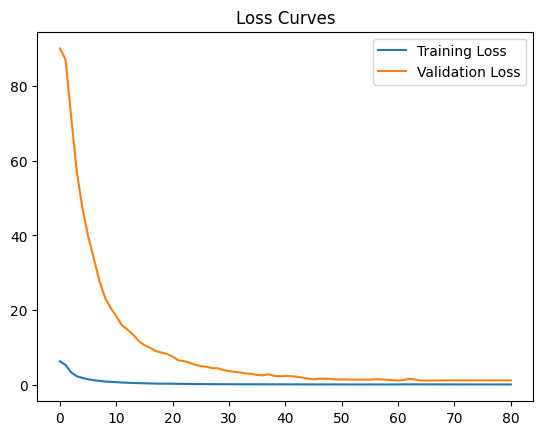

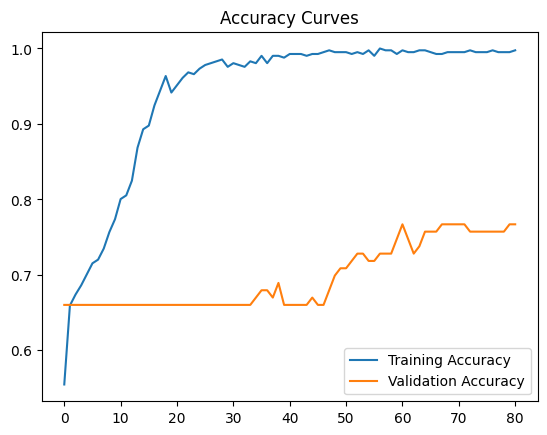

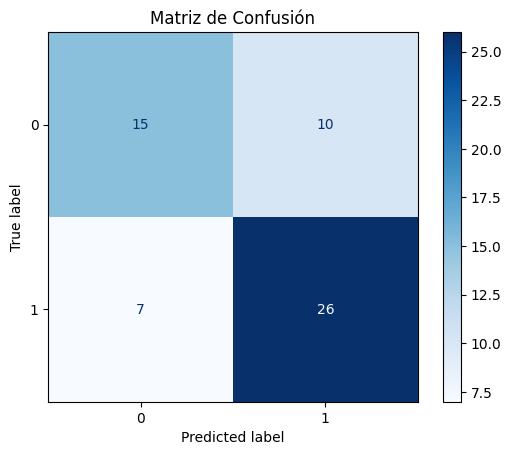

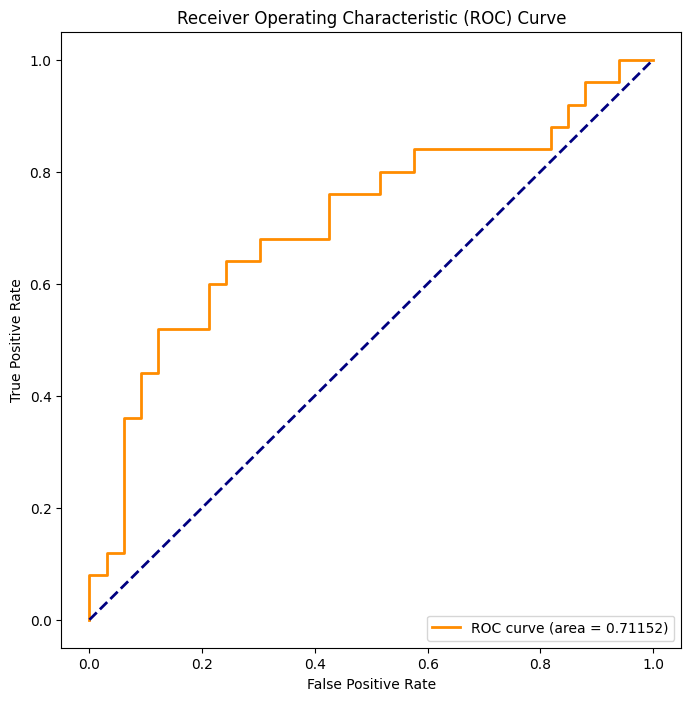


Entrenando Fold 2...
Epoch 1/999999
4/4 [==============================] - 22s 4s/step - loss: 6.0080 - accuracy: 0.5645 - val_loss: 90.5924 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 4.7120 - accuracy: 0.6715 - val_loss: 88.2161 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 2.9021 - accuracy: 0.6861 - val_loss: 70.0293 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.0399 - accuracy: 0.6691 - val_loss: 56.4398 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.5932 - accuracy: 0.6618 - val_loss: 46.3723 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.3795 - accuracy: 0.6715 - val_loss: 37.6697 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 7/999999
4/4 [======================

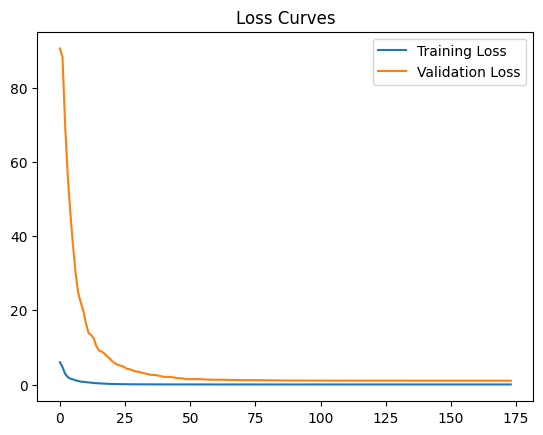

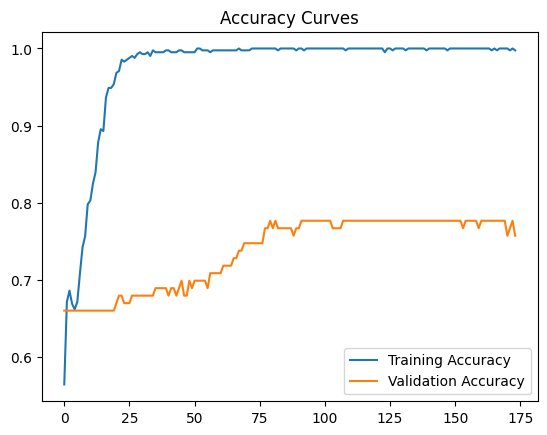

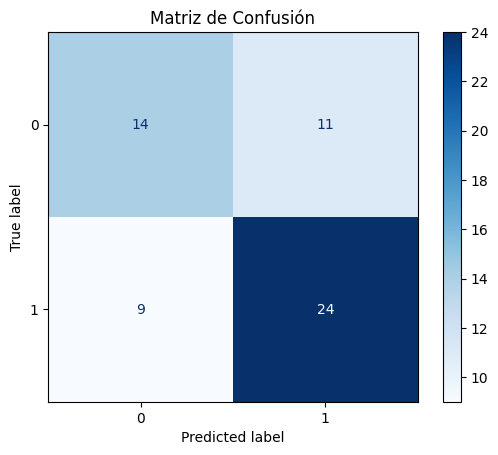

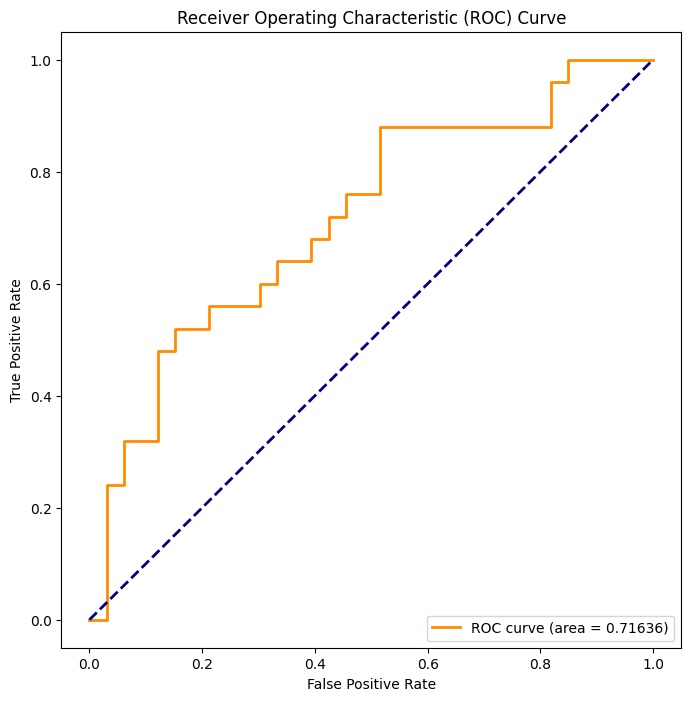


Entrenando Fold 3...
Epoch 1/999999
4/4 [==============================] - 22s 4s/step - loss: 5.7889 - accuracy: 0.5669 - val_loss: 79.5972 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 4.9498 - accuracy: 0.6837 - val_loss: 77.0242 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 2.6541 - accuracy: 0.6715 - val_loss: 65.0737 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 1.7464 - accuracy: 0.6959 - val_loss: 53.1792 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.3394 - accuracy: 0.7105 - val_loss: 43.5376 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.1561 - accuracy: 0.7445 - val_loss: 34.7734 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 7/999999
4/4 [======================

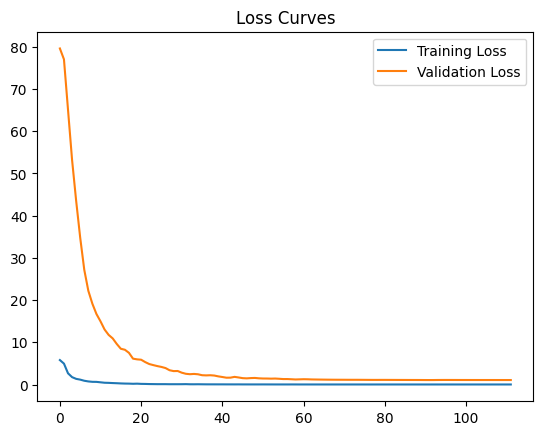

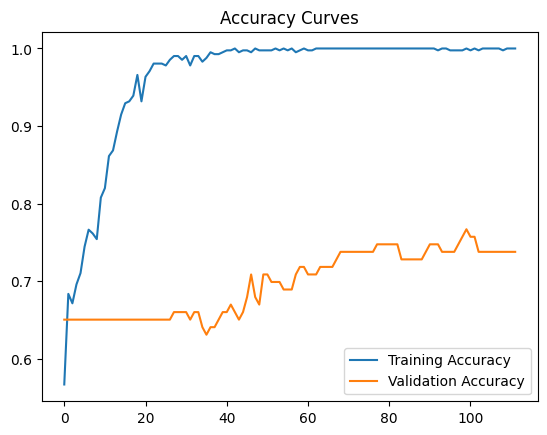

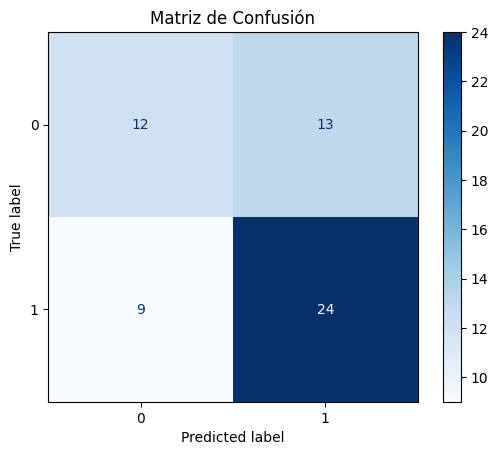

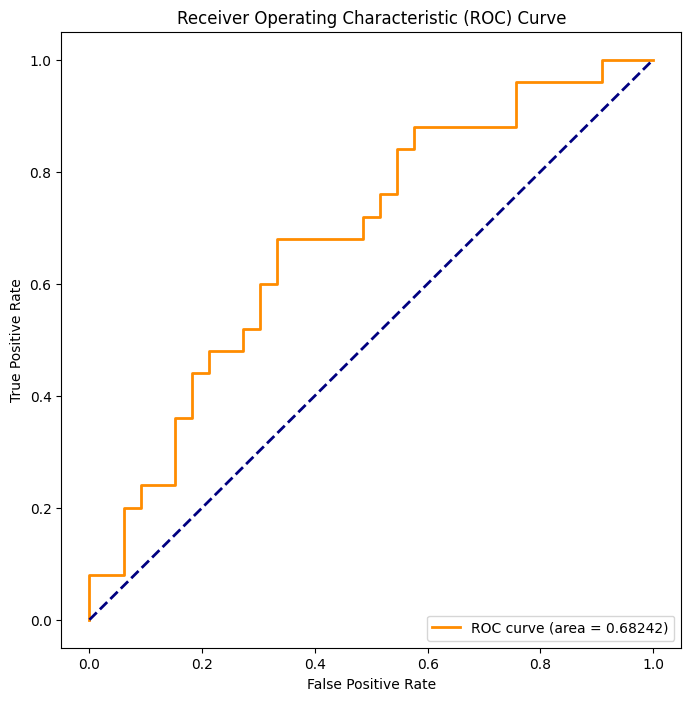


Entrenando Fold 4...
Epoch 1/999999
4/4 [==============================] - 22s 4s/step - loss: 5.7401 - accuracy: 0.5328 - val_loss: 93.0686 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 5.1088 - accuracy: 0.6667 - val_loss: 92.3791 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 3.3453 - accuracy: 0.6740 - val_loss: 76.2411 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.1930 - accuracy: 0.6813 - val_loss: 61.1422 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.7892 - accuracy: 0.6715 - val_loss: 47.7463 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.4386 - accuracy: 0.6642 - val_loss: 39.1387 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 7/999999
4/4 [======================

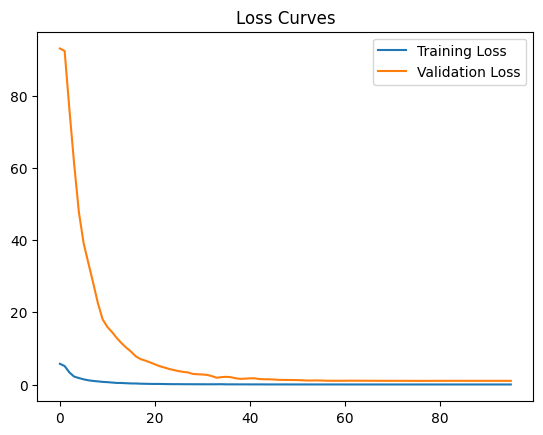

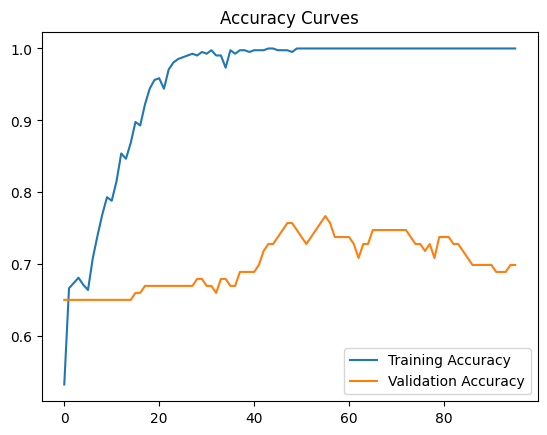

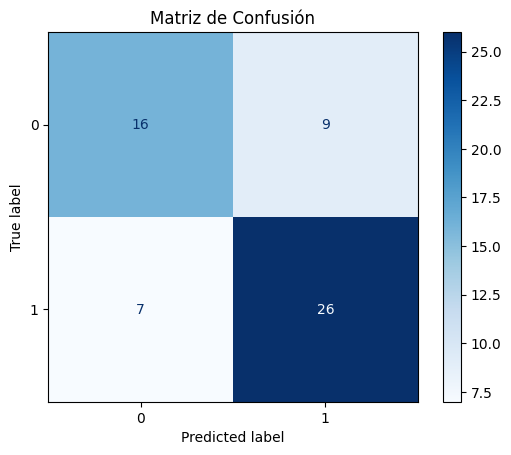

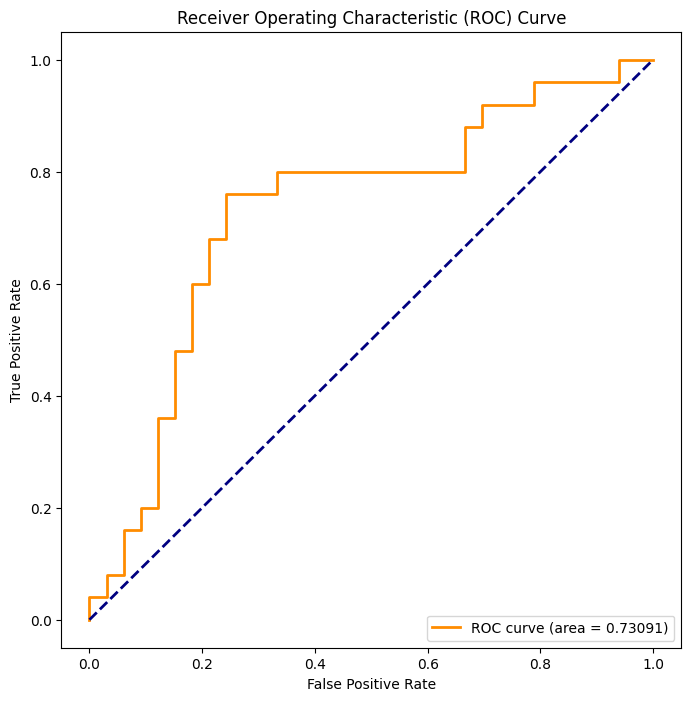


Entrenando Fold 5...
Epoch 1/999999
4/4 [==============================] - 49s 12s/step - loss: 6.4925 - accuracy: 0.5485 - val_loss: 79.0144 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 4.6366 - accuracy: 0.6675 - val_loss: 75.0202 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 2.7075 - accuracy: 0.6820 - val_loss: 63.1038 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 1.7456 - accuracy: 0.6869 - val_loss: 51.5761 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.4416 - accuracy: 0.6772 - val_loss: 43.9005 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.0980 - accuracy: 0.7233 - val_loss: 37.0029 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 7/999999
4/4 [=====================

2/2 [==============================] - 1s 295ms/step


----------------------------------------------
 METRICAS DE EVALUACIÓN PARA EL MODELO
----------------------------------------------
Accuracy on test set: 72.41379%
Loss on test set: 144.73771%
Precision on test set: 68.00000%
Recall on test set: 68.00000%
F1 Score on test set: 68.00000%
ROC AUC score on test set: 73.21212
El Score oficial del Challenge es: 46.66667


----------------------------------------------
 REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO
----------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        33
           1       0.68      0.68      0.68        25

    accuracy                           0.72        58
   macro avg       0.72      0.72      0.72        58
weighted avg       0.72      0.72      0.72        58



----------------------------------------------
 GRÁFICAS DE EVALUACIÓN
---------------------

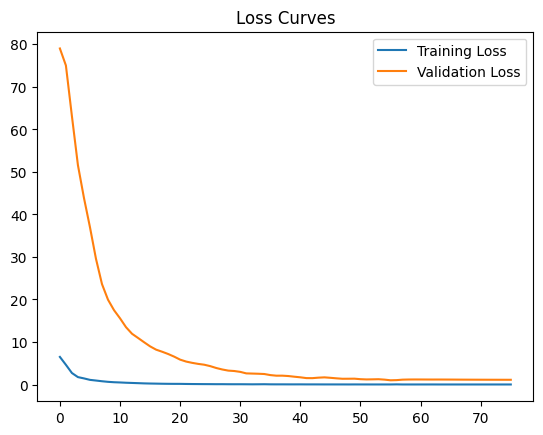

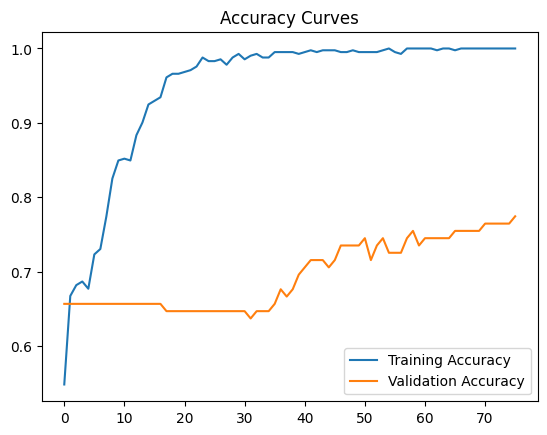

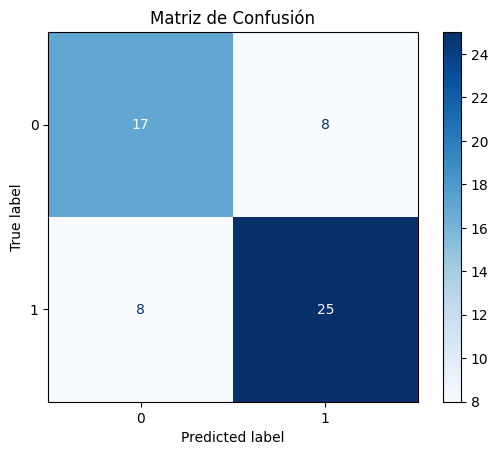

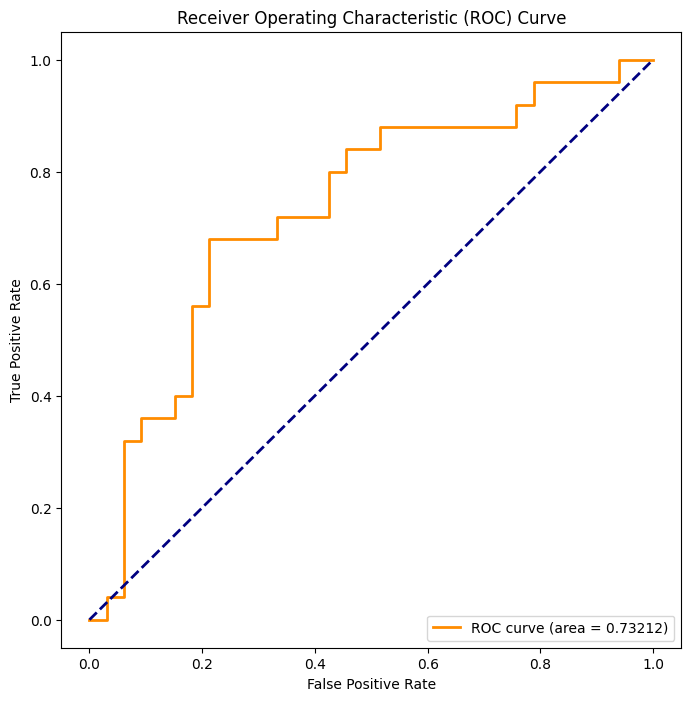



----------------------------------------------
 METRICAS DE EVALUACIÓN FINALES EN CADA FOLD
----------------------------------------------


 PARA ENTRENAMIENTO 
El accuracy de cada fold es:  [0.9951338171958923, 0.9951338171958923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9951456189155579, 0.9951456189155579]
La Media del accuracy de los k fols es: 0.99805588722229
La Desviación Estandar del accuracy de los k fols es: 0.002381045078687385
El accuracy mínimo es: 0.9956748421436026
El accuracy máximo es: 1.0004369323009774


 PARA VALIDACIÓN 
El accuracy de cada fold es:  [0.7669903039932251, 0.7669903039932251, 0.7669903039932251, 0.7669903039932251, 0.7475728392601013, 0.7475728392601013, 0.7281553149223328, 0.7281553149223328, 0.7254902124404907, 0.7254902124404907]
La Media del accuracy de los k fols es: 0.747039794921875
La Desviación Estandar del accuracy de los k fols es: 0.017985204200417937
El accuracy mínimo es: 0.7290545907214571
El accuracy máximo es: 0.7650249991222929


 PARA TES

In [ ]:
# Combinar datos para k-fold
X_combined = np.concatenate((X_train1, X_val1), axis=0)
y_combined = np.concatenate((y_train1, y_val1), axis=0)

n_folds = 5

#Para guardar los mejores accuracys
fold_train_accuracies = []
fold_val_accuracies = []
fold_test_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_roc_aucs = []
fold_score = []

# StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

initial_weights = None

# Entrenamiento con k-fold estratificado
for fold, (train_index, val_index) in enumerate(stratkf.split(X_combined, y_combined)):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]


    # Guardar los pesos iniciales en la primera iteración
    if initial_weights is None:
        initial_weights = model.get_weights()

    # Restablecer pesos a los valores iniciales
    model.set_weights(initial_weights)

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entrenamiento con callbacks para guardar el mejor modelo
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=20,verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,verbose=1),
        ModelCheckpoint(filepath=f"best_model_fold_{fold + 1}_P2C1_.keras", save_best_only=True)]

    print(f"\nEntrenando Fold {fold + 1}...")

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=999999,
        batch_size=128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks
    )

    #METRICAS DE EVALUACION DEL MODELO
    best_model = load_model(f"best_model_fold_{fold + 1}_P2C1_.keras")

    # Evaluar el mejor modelo en el conjunto de prueba

    test_loss, test_accuracy = best_model.evaluate(X_test1, y_test1)
    fold_test_accuracies.append(test_accuracy)

    # Evaluar el mejor modelo en el conjunto de entrenamiento
    train_loss, train_accuracy = best_model.evaluate(X_train_fold, y_train_fold)
    fold_train_accuracies.append(train_accuracy)     #

    # Evaluar el mejor modelo en el conjunto de validación
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)
    fold_val_accuracies.append(val_accuracy)


    # Obtener las predicciones en el conjunto de prueba
    y_pred_probs = best_model.predict(X_test1)

    # Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
    threshold = 0.5
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convertir las etiquetas a clases binarias
    y_true_binary = (y_test1 > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
    conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)
    fold_test_accuracies.append(test_accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_roc_aucs.append(roc_auc)



    # Extraer los valores de TP, FP, FN y TN de la matriz de confusión
    TP = conf_matrix[0, 0]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives
    TN = conf_matrix[1, 1]  # True Negatives

    # Calcular el score del challenge
    score = (TP + TN) / (TP + TN + FP + (5 * FN))
    fold_score.append(score)


    print("\n")
    print("----------------------------------------------")
    print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
    print("----------------------------------------------")
    print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
    print(f'Loss on test set: {test_loss * 100:.5f}%')
    print(f'Precision on test set: {precision * 100:.5f}%')
    print(f'Recall on test set: {recall * 100:.5f}%')
    print(f'F1 Score on test set: {f1 * 100:.5f}%')
    print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
    print(f'El Score oficial del Challenge es: {score * 100:.5f}')
    #######
    print("\n")
    print("----------------------------------------------")
    print(" REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO")
    print("----------------------------------------------")
    report=classification_report(y_true_binary,y_pred_binary)
    print(report)


    #######
    print("\n")
    print("----------------------------------------------")
    print(" GRÁFICAS DE EVALUACIÓN")
    print("----------------------------------------------")
    # Graficar curvas de pérdida y precisión
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    print("\n")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()
    print("\n")
    # Plotear la matriz de confusión
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusión')
    plt.show()
    print("\n")
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


print("\n")
print("----------------------------------------------")
print(" METRICAS DE EVALUACIÓN FINALES EN CADA FOLD")
print("----------------------------------------------")
print("\n")
print(" PARA ENTRENAMIENTO ")
print('El accuracy de cada fold es: ',fold_train_accuracies)
Media_TRAIN = np.mean(fold_train_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TRAIN}')
Desv_std_TRAIN = np.std(fold_train_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TRAIN}')

Min_TRAIN = Media_TRAIN - Desv_std_TRAIN
Max_TRAIN = Media_TRAIN + Desv_std_TRAIN
print(f'El accuracy mínimo es: {Min_TRAIN}')
print(f'El accuracy máximo es: {Max_TRAIN}')

print("\n")
print(" PARA VALIDACIÓN ")
print('El accuracy de cada fold es: ',fold_val_accuracies)
Media_VAL = np.mean(fold_val_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_VAL}')
Desv_std_VAL = np.std(fold_val_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_VAL}')

Min_VAL = Media_VAL - Desv_std_VAL
Max_VAL = Media_VAL + Desv_std_VAL
print(f'El accuracy mínimo es: {Min_VAL}')
print(f'El accuracy máximo es: {Max_VAL}')

print("\n")
print(" PARA TESTEO ")
print('El accuracy de cada fold es: ',fold_test_accuracies)
Media_TEST= np.mean(fold_test_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TEST}')
Desv_std_TEST = np.std(fold_test_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TEST}')

Min_TEST = Media_TEST - Desv_std_TEST
Max_TEST = Media_TEST + Desv_std_TEST
print(f'El accuracy mínimo es: {Min_TEST}')
print(f'El accuracy máximo es: {Max_TEST}')


print("\n")
print(" PARA LA MÉTRICA DE PRECISIÓN ")
print('La precisión cada fold es: ',fold_precisions)
mean_precision = np.mean(fold_precisions)
print(f'La Media de la precisión de los k fols es: {mean_precision}')
std_precision = np.std(fold_precisions)
print(f'La Desviación Estandar de la precisión de los k fols es: {std_precision}')
Min_precision = mean_precision - std_precision
Max_precision = mean_precision + std_precision
print(f'La precisión mínima es: {Min_precision}')
print(f'La precisión máxima es: {Max_precision}')


print("\n")
print(" PARA LA MÉTRICA DE RECALL ")
print('El recall de cada fold es: ',fold_recalls)
mean_recall = np.mean(fold_recalls)
print(f'La Media del recall de los k fols es: {mean_recall}')
std_recall = np.std(fold_recalls)
print(f'La Desviación Estandar del recall de los k fols es: {std_recall}')
Min_recall = mean_recall - std_recall
Max_recall = mean_recall + std_recall
print(f'El Recall mínimo es: {Min_recall}')
print(f'El Recall máximo es: {Max_recall}')


print("\n")
print(" PARA LA MÉTRICA DE F1 SCORE ")
print('El F1 SCORE de cada fold es: ',fold_f1_scores)
mean_f1_score = np.mean(fold_f1_scores)
print(f'La Media del F1 SCORE de los k fols es: {mean_f1_score}')
std_f1_score = np.std(fold_f1_scores)
print(f'La Desviación Estandar del F1 SCORE de los k fols es: {std_f1_score}')
Min_f1_score = mean_f1_score - std_f1_score
Max_f1_score = mean_f1_score + std_f1_score
print(f'El F1 SCORE mínimo es: {Min_f1_score}')
print(f'El F1 SCORE máximo es: {Max_f1_score}')


print("\n")
print(" PARA EL ROC SCORE ")
print('El ROC SCORE de cada fold es: ',fold_roc_aucs)
mean_roc_auc = np.mean(fold_roc_aucs)
print(f'La Media del ROC SCORE de los k fols es: {mean_roc_auc}')
std_roc_auc = np.std(fold_roc_aucs)
print(f'La Desviación Estandar del ROC SCORE de los k fols es: {std_roc_auc}')
Min_roc_auc = mean_roc_auc - std_roc_auc
Max_roc_auc = mean_roc_auc + std_roc_auc
print(f'El ROC SCORE mínimo es: {Min_roc_auc}')
print(f'El ROC SCORE máximo es: {Max_roc_auc}')


print("\n")
print(" PARA EL SCORE DEL PHYSIONET")
print('El SCORE de cada fold es: ',fold_score)
mean_score = np.mean(fold_score)
print(f'La Media del SCORE de los k fols es: {mean_score}')
std_score = np.std(fold_score)
print(f'La Desviación Estandar del SCORE de los k fols es: {std_score}')
Min_score = mean_score - std_score
Max_score = mean_score + std_score
print(f'El SCORE mínimo es: {Min_score}')
print(f'El SCORE máximo es: {Max_score}')

###PRUEBA 3. MB + 5 folds  + Callbacks (Early stopping con 20 épocas de paciencia  + REDUCE + Save) + L2 = 0.0005

In [ ]:
samples_per_signal = 75000
num_of_signals = 3


# Definir el valor de regularización L2
l2_reg = 0.0005

input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(l2_reg))(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

Model: "signal_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75000, 3)]           0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 75000, 3)             12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 15000, 64)            9664      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 15000, 64)            19264     ['batch_normaliza

In [ ]:
# Compila el modelo
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    loss= keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])


Entrenando Fold 1...
Epoch 1/999999
4/4 [==============================] - 138s 16s/step - loss: 6.6276 - accuracy: 0.5693 - val_loss: 88.3377 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 5.6855 - accuracy: 0.6715 - val_loss: 77.1551 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 3.2490 - accuracy: 0.6910 - val_loss: 58.7489 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.1761 - accuracy: 0.6886 - val_loss: 46.6720 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.7007 - accuracy: 0.6764 - val_loss: 38.3396 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.4759 - accuracy: 0.7153 - val_loss: 29.3704 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 7/999999
4/4 [====================

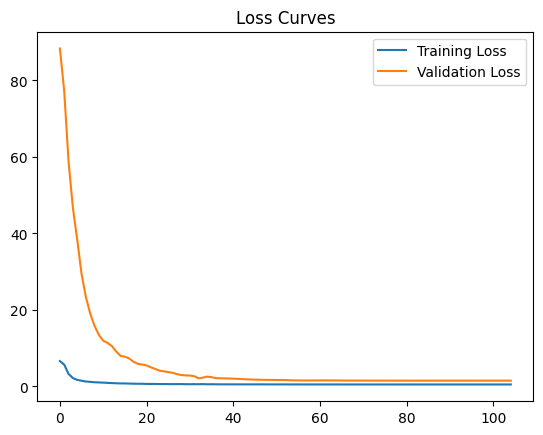

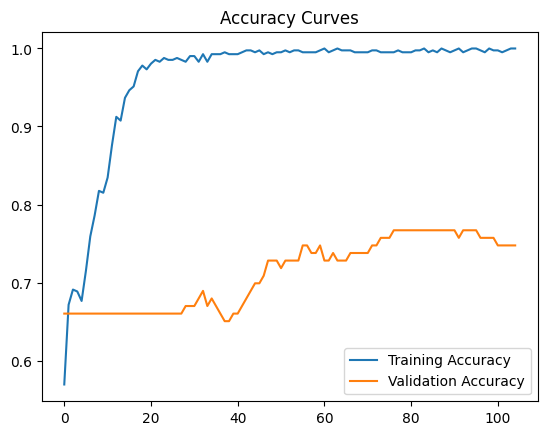

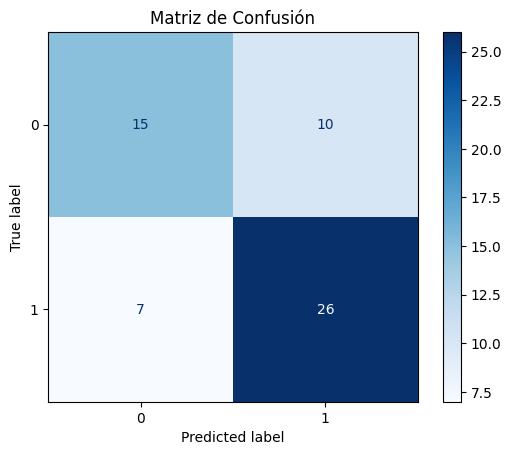

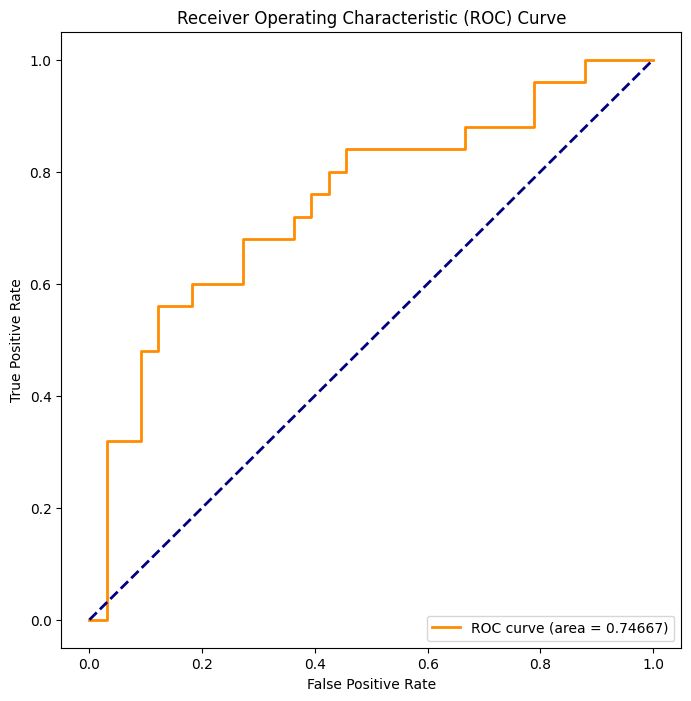


Entrenando Fold 2...
Epoch 1/999999
4/4 [==============================] - 23s 4s/step - loss: 6.8895 - accuracy: 0.5255 - val_loss: 98.0147 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 5.6627 - accuracy: 0.6813 - val_loss: 84.5582 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 3.5016 - accuracy: 0.6910 - val_loss: 63.9305 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.5452 - accuracy: 0.6788 - val_loss: 50.8849 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.9748 - accuracy: 0.6788 - val_loss: 42.6883 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.7233 - accuracy: 0.7032 - val_loss: 35.7376 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 7/999999
4/4 [======================

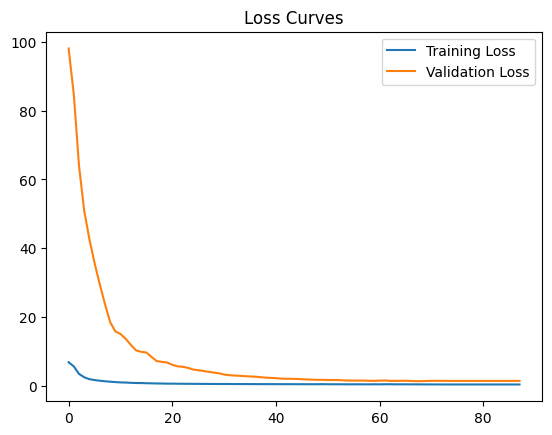

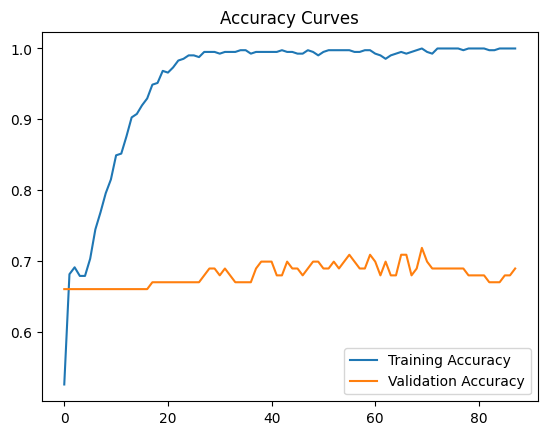

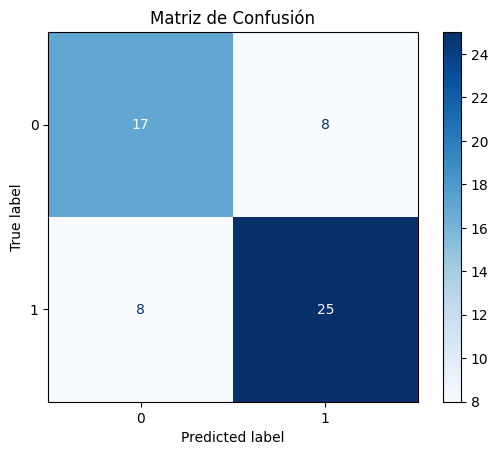

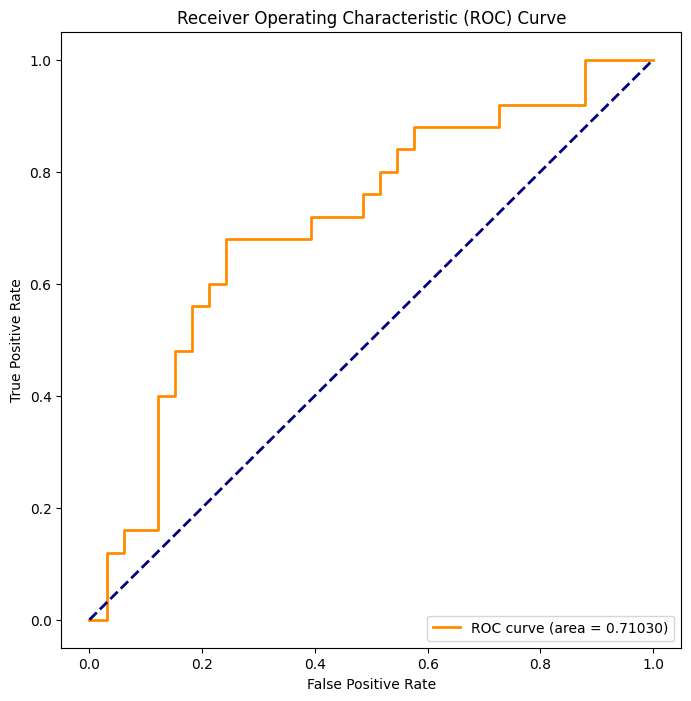


Entrenando Fold 3...
Epoch 1/999999
4/4 [==============================] - 24s 4s/step - loss: 6.5656 - accuracy: 0.5888 - val_loss: 83.5996 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 5.7881 - accuracy: 0.6715 - val_loss: 74.8034 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 16s 4s/step - loss: 2.8419 - accuracy: 0.6715 - val_loss: 57.4717 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.2609 - accuracy: 0.6399 - val_loss: 46.0355 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.6443 - accuracy: 0.6910 - val_loss: 37.7836 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.3768 - accuracy: 0.7494 - val_loss: 28.9909 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 7/999999
4/4 [======================

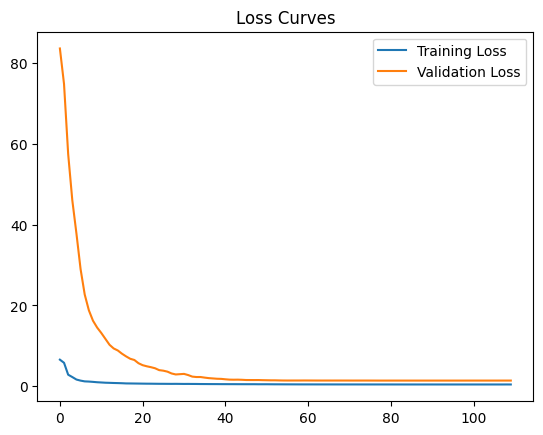

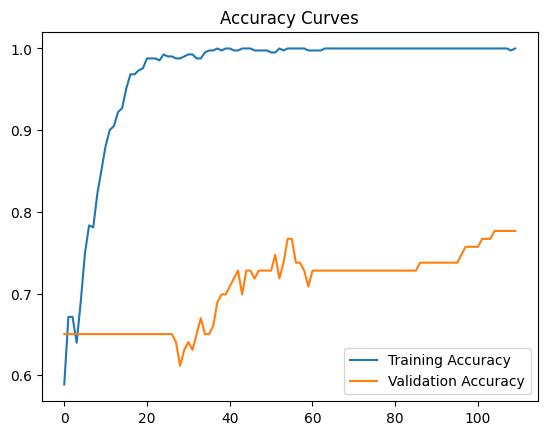

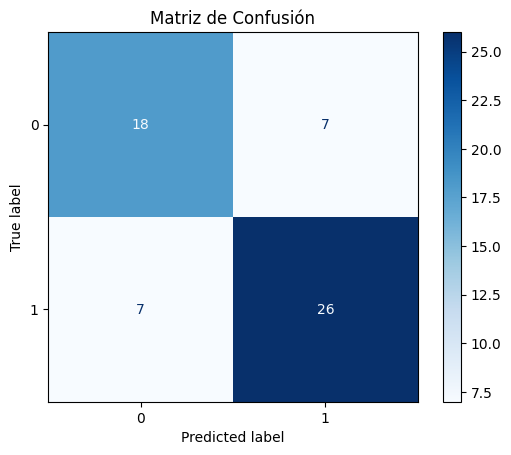

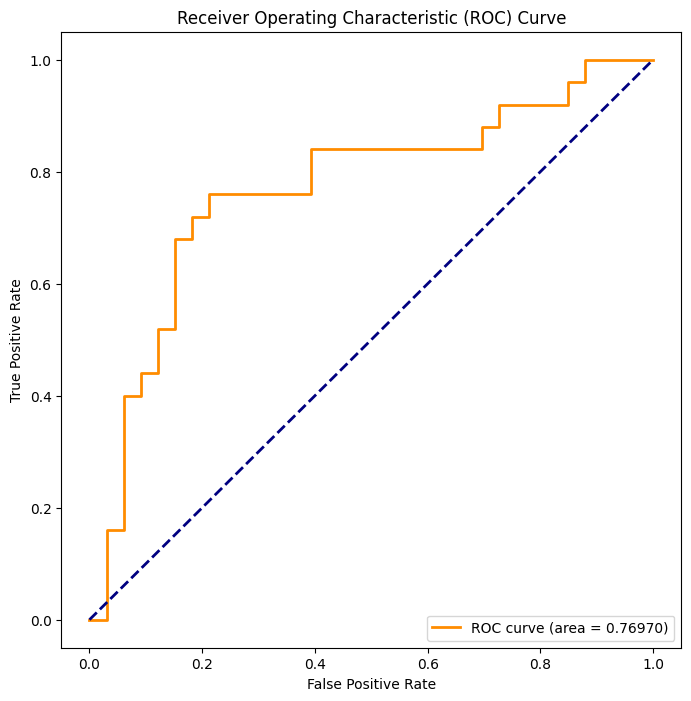


Entrenando Fold 4...
Epoch 1/999999
4/4 [==============================] - 22s 4s/step - loss: 5.9766 - accuracy: 0.5961 - val_loss: 95.9058 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 5.8932 - accuracy: 0.6667 - val_loss: 84.3874 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 16s 4s/step - loss: 3.3273 - accuracy: 0.6910 - val_loss: 63.6093 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.0941 - accuracy: 0.7007 - val_loss: 49.8124 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.8218 - accuracy: 0.6861 - val_loss: 41.2149 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.6131 - accuracy: 0.7032 - val_loss: 34.7527 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 7/999999
4/4 [======================

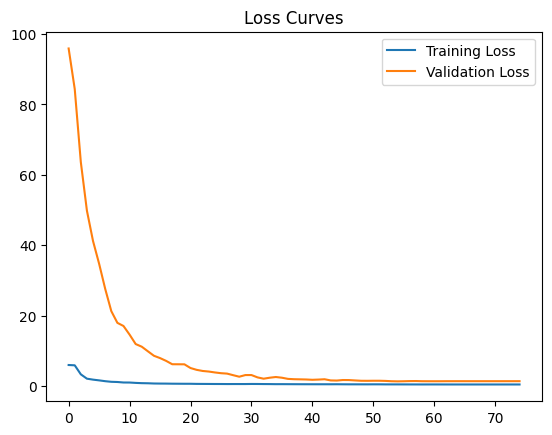

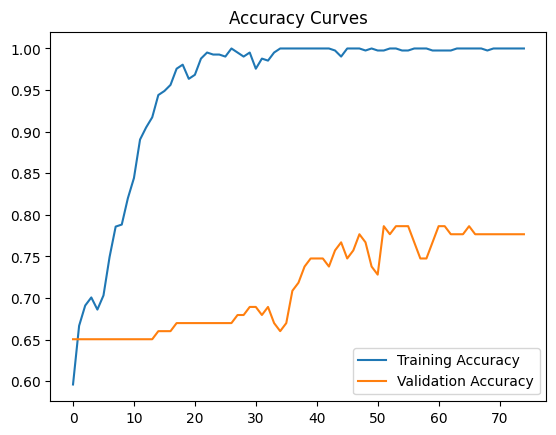

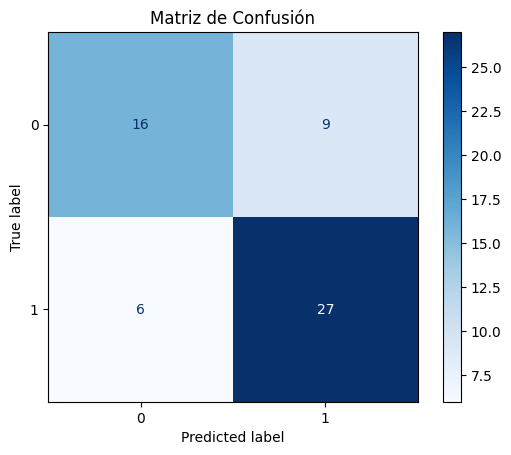

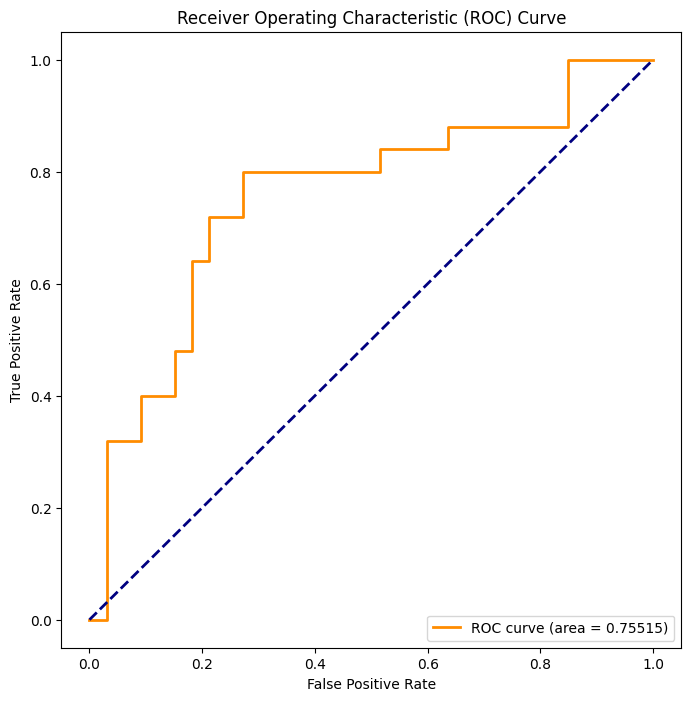


Entrenando Fold 5...
Epoch 1/999999
4/4 [==============================] - 61s 16s/step - loss: 7.1030 - accuracy: 0.5437 - val_loss: 82.5678 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 5.6785 - accuracy: 0.6748 - val_loss: 72.9123 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 3.4093 - accuracy: 0.6893 - val_loss: 53.7931 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 16s 4s/step - loss: 2.5788 - accuracy: 0.6796 - val_loss: 43.9096 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.8536 - accuracy: 0.6796 - val_loss: 38.5586 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.6000 - accuracy: 0.7136 - val_loss: 30.0485 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 7/999999
4/4 [=====================

2/2 [==============================] - 1s 310ms/step


----------------------------------------------
 METRICAS DE EVALUACIÓN PARA EL MODELO
----------------------------------------------
Accuracy on test set: 65.51724%
Loss on test set: 144.31150%
Precision on test set: 58.62069%
Recall on test set: 68.00000%
F1 Score on test set: 62.96296%
ROC AUC score on test set: 73.81818
El Score oficial del Challenge es: 35.84906


----------------------------------------------
 REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO
----------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.64      0.68        33
           1       0.59      0.68      0.63        25

    accuracy                           0.66        58
   macro avg       0.66      0.66      0.65        58
weighted avg       0.66      0.66      0.66        58



----------------------------------------------
 GRÁFICAS DE EVALUACIÓN
---------------------

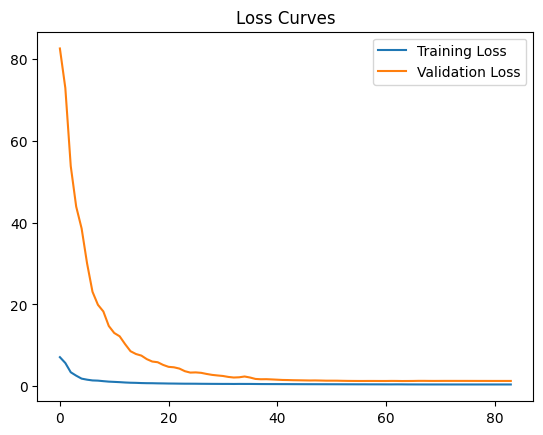

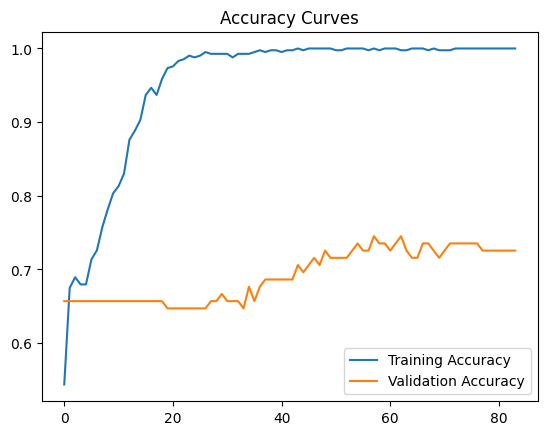

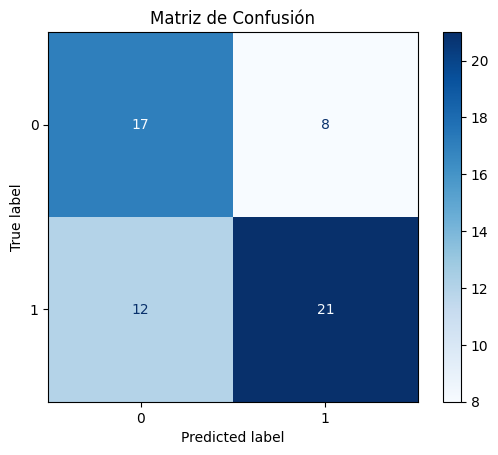

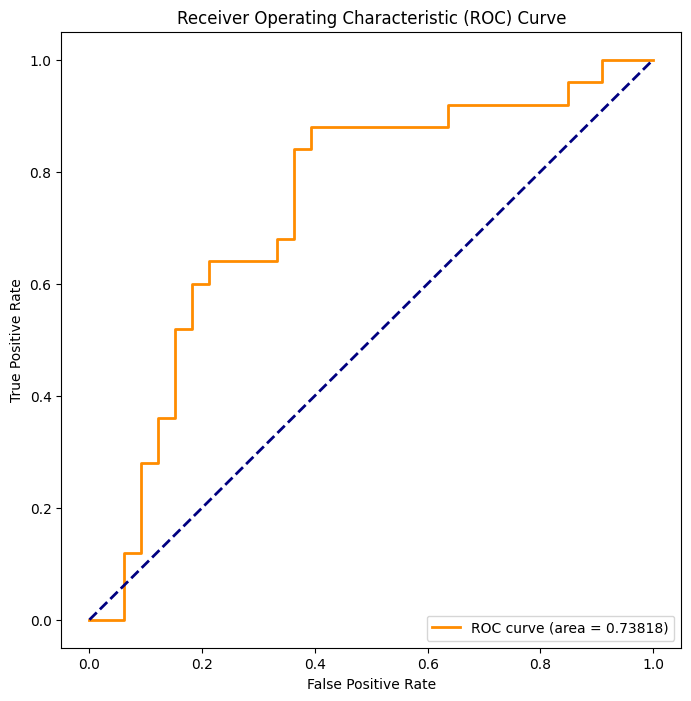



----------------------------------------------
 METRICAS DE EVALUACIÓN FINALES EN CADA FOLD
----------------------------------------------


 PARA ENTRENAMIENTO 
El accuracy de cada fold es:  [0.9951338171958923, 0.9951338171958923, 0.9975669384002686, 0.9975669384002686, 1.0, 1.0, 0.9975669384002686, 0.9975669384002686, 0.9975728392601013, 0.9975728392601013]
La Media del accuracy de los k fols es: 0.9975681066513061
La Desviación Estandar del accuracy de los k fols es: 0.0015388239366066062
El accuracy mínimo es: 0.9960292827146995
El accuracy máximo es: 0.9991069305879128


 PARA VALIDACIÓN 
El accuracy de cada fold es:  [0.7669903039932251, 0.7669903039932251, 0.6796116232872009, 0.6796116232872009, 0.737864077091217, 0.737864077091217, 0.7864077687263489, 0.7864077687263489, 0.7254902124404907, 0.7254902124404907]
La Media del accuracy de los k fols es: 0.7392727971076966
La Desviación Estandar del accuracy de los k fols es: 0.03671883857442498
El accuracy mínimo es: 0.702553958

In [ ]:
# Combinar datos para k-fold
X_combined = np.concatenate((X_train1, X_val1), axis=0)
y_combined = np.concatenate((y_train1, y_val1), axis=0)

n_folds = 5

#Para guardar los mejores accuracys
fold_train_accuracies = []
fold_val_accuracies = []
fold_test_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_roc_aucs = []
fold_score = []

# StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

initial_weights = None

# Entrenamiento con k-fold estratificado
for fold, (train_index, val_index) in enumerate(stratkf.split(X_combined, y_combined)):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]


    # Guardar los pesos iniciales en la primera iteración
    if initial_weights is None:
        initial_weights = model.get_weights()

    # Restablecer pesos a los valores iniciales
    model.set_weights(initial_weights)

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entrenamiento con callbacks para guardar el mejor modelo
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=20,verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,verbose=1),
        ModelCheckpoint(filepath=f"best_model_fold_{fold + 1}_P3C1_.keras", save_best_only=True)]

    print(f"\nEntrenando Fold {fold + 1}...")

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=999999,
        batch_size=128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks
    )

    #METRICAS DE EVALUACION DEL MODELO
    best_model = load_model(f"best_model_fold_{fold + 1}_P3C1_.keras")

    # Evaluar el mejor modelo en el conjunto de prueba

    test_loss, test_accuracy = best_model.evaluate(X_test1, y_test1)
    fold_test_accuracies.append(test_accuracy)

    # Evaluar el mejor modelo en el conjunto de entrenamiento
    train_loss, train_accuracy = best_model.evaluate(X_train_fold, y_train_fold)
    fold_train_accuracies.append(train_accuracy)

    # Evaluar el mejor modelo en el conjunto de validación
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)
    fold_val_accuracies.append(val_accuracy)


    # Obtener las predicciones en el conjunto de prueba
    y_pred_probs = best_model.predict(X_test1)

    # Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
    threshold = 0.5
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convertir las etiquetas a clases binarias
    y_true_binary = (y_test1 > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
    conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)
    fold_test_accuracies.append(test_accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_roc_aucs.append(roc_auc)



    # Extraer los valores de TP, FP, FN y TN de la matriz de confusión
    TP = conf_matrix[0, 0]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives
    TN = conf_matrix[1, 1]  # True Negatives

    # Calcular el score del challenge
    score = (TP + TN) / (TP + TN + FP + (5 * FN))
    fold_score.append(score)


    print("\n")
    print("----------------------------------------------")
    print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
    print("----------------------------------------------")
    print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
    print(f'Loss on test set: {test_loss * 100:.5f}%')
    print(f'Precision on test set: {precision * 100:.5f}%')
    print(f'Recall on test set: {recall * 100:.5f}%')
    print(f'F1 Score on test set: {f1 * 100:.5f}%')
    print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
    print(f'El Score oficial del Challenge es: {score * 100:.5f}')
    #######
    print("\n")
    print("----------------------------------------------")
    print(" REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO")
    print("----------------------------------------------")
    report=classification_report(y_true_binary,y_pred_binary)
    print(report)


    #######
    print("\n")
    print("----------------------------------------------")
    print(" GRÁFICAS DE EVALUACIÓN")
    print("----------------------------------------------")
    # Graficar curvas de pérdida y precisión
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    print("\n")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()
    print("\n")
    # Plotear la matriz de confusión
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusión')
    plt.show()
    print("\n")
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


print("\n")
print("----------------------------------------------")
print(" METRICAS DE EVALUACIÓN FINALES EN CADA FOLD")
print("----------------------------------------------")
print("\n")
print(" PARA ENTRENAMIENTO ")
print('El accuracy de cada fold es: ',fold_train_accuracies)
Media_TRAIN = np.mean(fold_train_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TRAIN}')
Desv_std_TRAIN = np.std(fold_train_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TRAIN}')

Min_TRAIN = Media_TRAIN - Desv_std_TRAIN
Max_TRAIN = Media_TRAIN + Desv_std_TRAIN
print(f'El accuracy mínimo es: {Min_TRAIN}')
print(f'El accuracy máximo es: {Max_TRAIN}')

print("\n")
print(" PARA VALIDACIÓN ")
print('El accuracy de cada fold es: ',fold_val_accuracies)
Media_VAL = np.mean(fold_val_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_VAL}')
Desv_std_VAL = np.std(fold_val_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_VAL}')

Min_VAL = Media_VAL - Desv_std_VAL
Max_VAL = Media_VAL + Desv_std_VAL
print(f'El accuracy mínimo es: {Min_VAL}')
print(f'El accuracy máximo es: {Max_VAL}')

print("\n")
print(" PARA TESTEO ")
print('El accuracy de cada fold es: ',fold_test_accuracies)
Media_TEST= np.mean(fold_test_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TEST}')
Desv_std_TEST = np.std(fold_test_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TEST}')

Min_TEST = Media_TEST - Desv_std_TEST
Max_TEST = Media_TEST + Desv_std_TEST
print(f'El accuracy mínimo es: {Min_TEST}')
print(f'El accuracy máximo es: {Max_TEST}')


print("\n")
print(" PARA LA MÉTRICA DE PRECISIÓN ")
print('La precisión cada fold es: ',fold_precisions)
mean_precision = np.mean(fold_precisions)
print(f'La Media de la precisión de los k fols es: {mean_precision}')
std_precision = np.std(fold_precisions)
print(f'La Desviación Estandar de la precisión de los k fols es: {std_precision}')
Min_precision = mean_precision - std_precision
Max_precision = mean_precision + std_precision
print(f'La precisión mínima es: {Min_precision}')
print(f'La precisión máxima es: {Max_precision}')


print("\n")
print(" PARA LA MÉTRICA DE RECALL ")
print('El recall de cada fold es: ',fold_recalls)
mean_recall = np.mean(fold_recalls)
print(f'La Media del recall de los k fols es: {mean_recall}')
std_recall = np.std(fold_recalls)
print(f'La Desviación Estandar del recall de los k fols es: {std_recall}')
Min_recall = mean_recall - std_recall
Max_recall = mean_recall + std_recall
print(f'El Recall mínimo es: {Min_recall}')
print(f'El Recall máximo es: {Max_recall}')


print("\n")
print(" PARA LA MÉTRICA DE F1 SCORE ")
print('El F1 SCORE de cada fold es: ',fold_f1_scores)
mean_f1_score = np.mean(fold_f1_scores)
print(f'La Media del F1 SCORE de los k fols es: {mean_f1_score}')
std_f1_score = np.std(fold_f1_scores)
print(f'La Desviación Estandar del F1 SCORE de los k fols es: {std_f1_score}')
Min_f1_score = mean_f1_score - std_f1_score
Max_f1_score = mean_f1_score + std_f1_score
print(f'El F1 SCORE mínimo es: {Min_f1_score}')
print(f'El F1 SCORE máximo es: {Max_f1_score}')


print("\n")
print(" PARA EL ROC SCORE ")
print('El ROC SCORE de cada fold es: ',fold_roc_aucs)
mean_roc_auc = np.mean(fold_roc_aucs)
print(f'La Media del ROC SCORE de los k fols es: {mean_roc_auc}')
std_roc_auc = np.std(fold_roc_aucs)
print(f'La Desviación Estandar del ROC SCORE de los k fols es: {std_roc_auc}')
Min_roc_auc = mean_roc_auc - std_roc_auc
Max_roc_auc = mean_roc_auc + std_roc_auc
print(f'El ROC SCORE mínimo es: {Min_roc_auc}')
print(f'El ROC SCORE máximo es: {Max_roc_auc}')


print("\n")
print(" PARA EL SCORE DEL PHYSIONET")
print('El SCORE de cada fold es: ',fold_score)
mean_score = np.mean(fold_score)
print(f'La Media del SCORE de los k fols es: {mean_score}')
std_score = np.std(fold_score)
print(f'La Desviación Estandar del SCORE de los k fols es: {std_score}')
Min_score = mean_score - std_score
Max_score = mean_score + std_score
print(f'El SCORE mínimo es: {Min_score}')
print(f'El SCORE máximo es: {Max_score}')

###PRUEBA 4. MB + 5 folds  + Callbacks (Early stopping con 20 épocas de paciencia  + REDUCE + Save) + Dropout = 0.85

In [ ]:
samples_per_signal = 75000
num_of_signals = 3


input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = layers.Dropout(0.85)(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = layers.Dropout(0.85)(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = layers.Dropout(0.85)(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform')(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform')(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = layers.Dropout(0.85)(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform')(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform')(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

Model: "signal_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75000, 3)]           0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 75000, 3)             12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 15000, 64)            9664      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 15000, 64)            19264     ['batch_normaliza

In [ ]:
# Compila el modelo
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    loss= keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])


Entrenando Fold 1...
Epoch 1/999999
4/4 [==============================] - 143s 17s/step - loss: 2.8352 - accuracy: 0.5353 - val_loss: 10.1997 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 1.6428 - accuracy: 0.6667 - val_loss: 2.8472 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 16s 4s/step - loss: 1.2408 - accuracy: 0.5815 - val_loss: 9.3136 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 16s 4s/step - loss: 1.1760 - accuracy: 0.7105 - val_loss: 11.0899 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 16s 4s/step - loss: 0.7123 - accuracy: 0.6618 - val_loss: 6.0554 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - ETA: 0s - loss: 0.8005 - accuracy: 0.6521
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4/4 [=====================

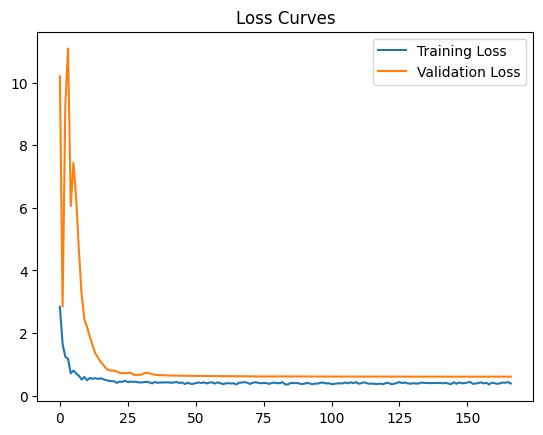

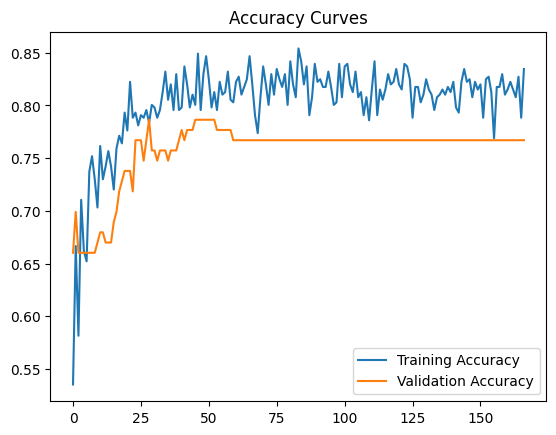

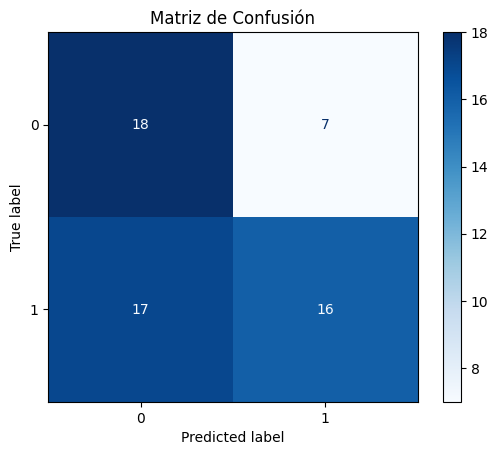

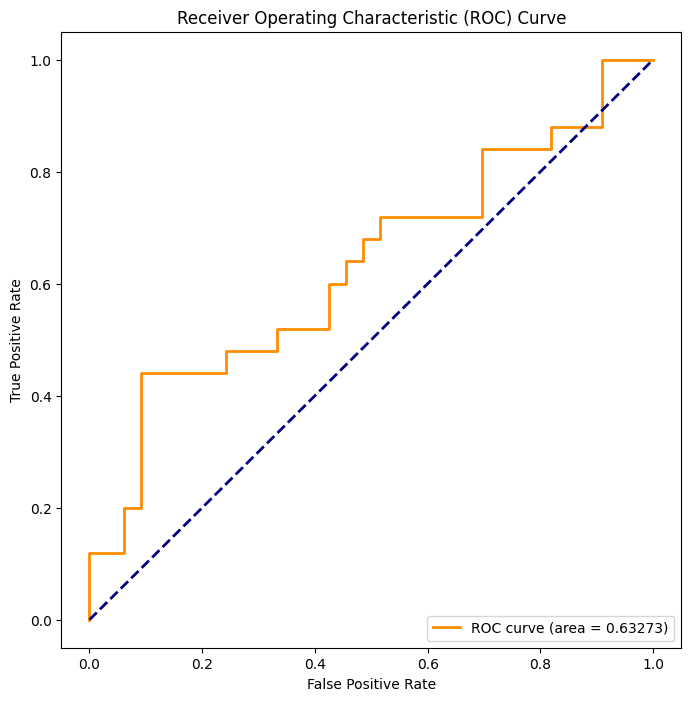


Entrenando Fold 2...
Epoch 1/999999
4/4 [==============================] - 23s 4s/step - loss: 1.7914 - accuracy: 0.5815 - val_loss: 4.7420 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 1.0805 - accuracy: 0.6326 - val_loss: 6.0622 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 16s 4s/step - loss: 0.7446 - accuracy: 0.7080 - val_loss: 6.5498 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 16s 4s/step - loss: 0.6411 - accuracy: 0.7153 - val_loss: 5.4060 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 16s 4s/step - loss: 0.5641 - accuracy: 0.7518 - val_loss: 2.5154 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 16s 4s/step - loss: 0.6330 - accuracy: 0.7421 - val_loss: 3.6434 - val_accuracy: 0.6408 - lr: 0.0010
Epoch 7/999999
4/4 [============================

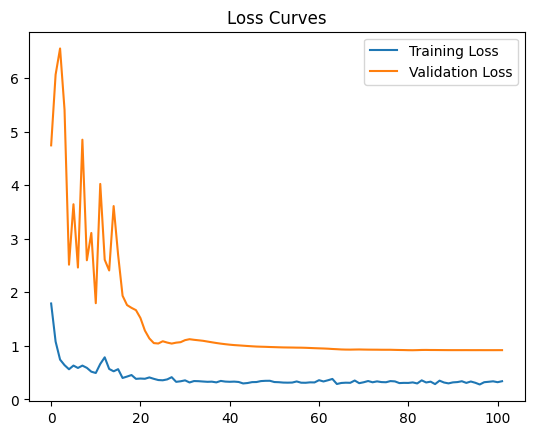

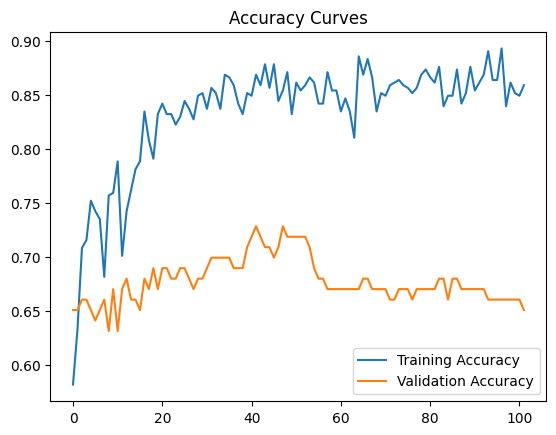

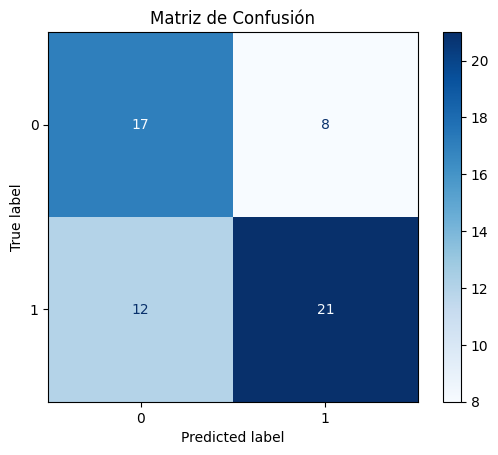

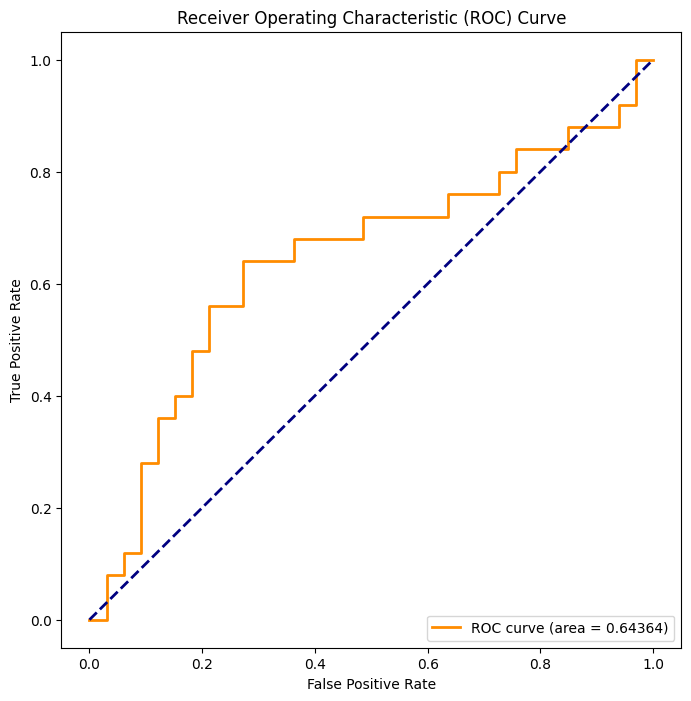


Entrenando Fold 3...
Epoch 1/999999
4/4 [==============================] - 23s 4s/step - loss: 2.3480 - accuracy: 0.5669 - val_loss: 8.9329 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 1.5367 - accuracy: 0.6618 - val_loss: 2.2873 - val_accuracy: 0.6699 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 16s 4s/step - loss: 1.2710 - accuracy: 0.5718 - val_loss: 9.8757 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 1.0772 - accuracy: 0.7226 - val_loss: 8.8810 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 16s 4s/step - loss: 0.7849 - accuracy: 0.6691 - val_loss: 6.5560 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.6472
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4/4 [=========================

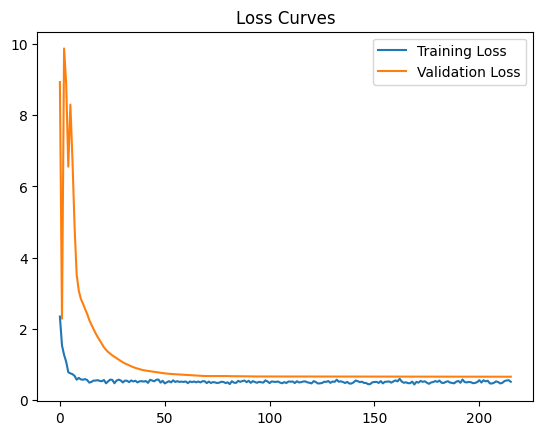

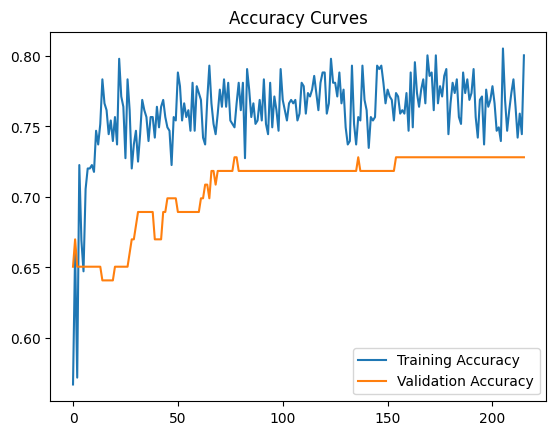

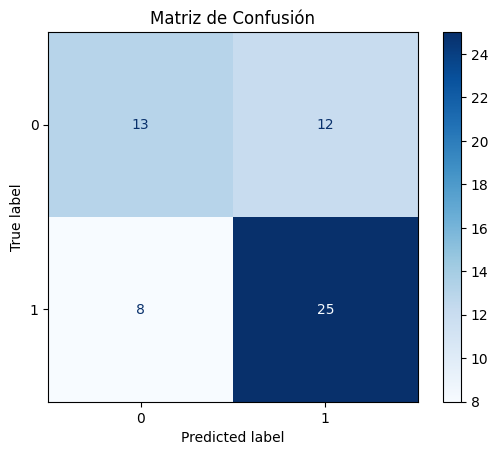

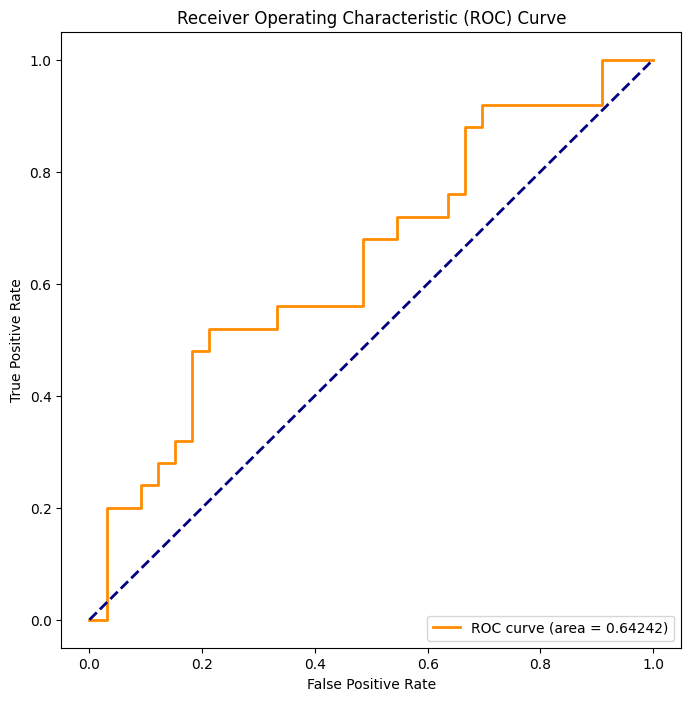


Entrenando Fold 4...
Epoch 1/999999
4/4 [==============================] - 23s 4s/step - loss: 2.3090 - accuracy: 0.5572 - val_loss: 8.3105 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 1.1624 - accuracy: 0.6642 - val_loss: 3.2458 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 16s 4s/step - loss: 1.0415 - accuracy: 0.6496 - val_loss: 12.2742 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 16s 4s/step - loss: 0.8081 - accuracy: 0.7153 - val_loss: 7.1745 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 16s 4s/step - loss: 0.9255 - accuracy: 0.5669 - val_loss: 11.1070 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - ETA: 0s - loss: 0.9077 - accuracy: 0.7056
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4/4 [=======================

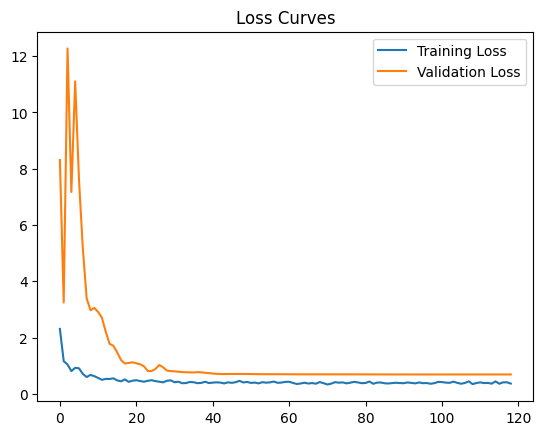

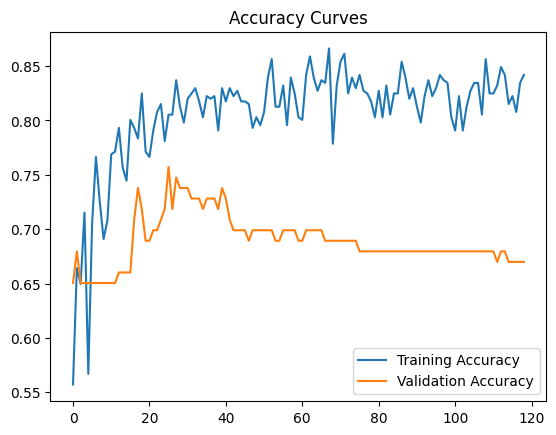

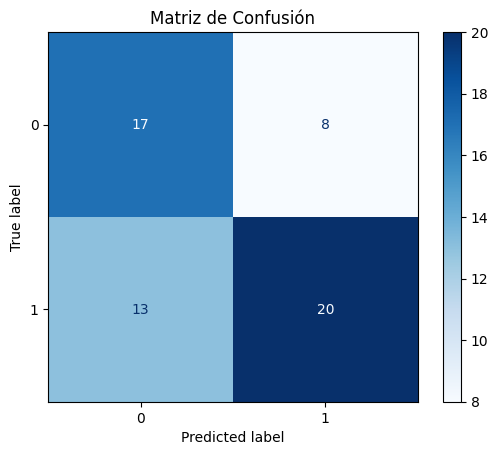

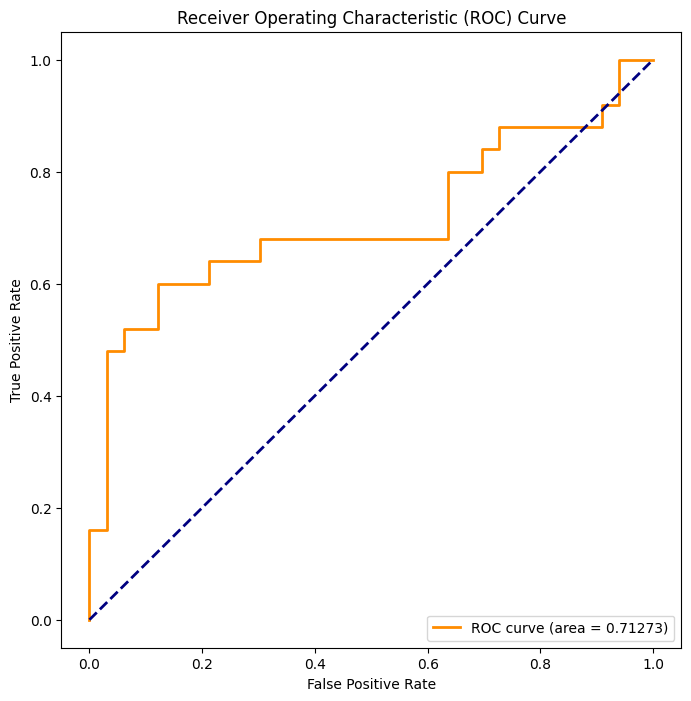


Entrenando Fold 5...
Epoch 1/999999
4/4 [==============================] - 61s 17s/step - loss: 2.4162 - accuracy: 0.5534 - val_loss: 5.8156 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 1.2658 - accuracy: 0.6529 - val_loss: 2.0338 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 16s 4s/step - loss: 1.1780 - accuracy: 0.6092 - val_loss: 13.8626 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 16s 4s/step - loss: 1.2004 - accuracy: 0.7063 - val_loss: 8.3203 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 16s 4s/step - loss: 0.9961 - accuracy: 0.5850 - val_loss: 8.6187 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - ETA: 0s - loss: 0.7573 - accuracy: 0.7379
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4/4 [=======================

In [ ]:
# Combinar datos para k-fold
X_combined = np.concatenate((X_train1, X_val1), axis=0)
y_combined = np.concatenate((y_train1, y_val1), axis=0)

n_folds = 5

#Para guardar los mejores accuracys
fold_train_accuracies = []
fold_val_accuracies = []
fold_test_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_roc_aucs = []
fold_score = []

# StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

initial_weights = None

# Entrenamiento con k-fold estratificado
for fold, (train_index, val_index) in enumerate(stratkf.split(X_combined, y_combined)):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]


    # Guardar los pesos iniciales en la primera iteración
    if initial_weights is None:
        initial_weights = model.get_weights()

    # Restablecer pesos a los valores iniciales
    model.set_weights(initial_weights)

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entrenamiento con callbacks para guardar el mejor modelo
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=20,verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,verbose=1),
        ModelCheckpoint(filepath=f"best_model_fold_{fold + 1}_P4C1_.keras", save_best_only=True)]

    print(f"\nEntrenando Fold {fold + 1}...")

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=999999,
        batch_size=128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks
    )

    #METRICAS DE EVALUACION DEL MODELO
    best_model = load_model(f"best_model_fold_{fold + 1}_P4C1_.keras")

    # Evaluar el mejor modelo en el conjunto de prueba

    test_loss, test_accuracy = best_model.evaluate(X_test1, y_test1)
    fold_test_accuracies.append(test_accuracy)

    # Evaluar el mejor modelo en el conjunto de entrenamiento
    train_loss, train_accuracy = best_model.evaluate(X_train_fold, y_train_fold)
    fold_train_accuracies.append(train_accuracy)

    # Evaluar el mejor modelo en el conjunto de validación
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)
    fold_val_accuracies.append(val_accuracy)


    # Obtener las predicciones en el conjunto de prueba
    y_pred_probs = best_model.predict(X_test1)

    # Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
    threshold = 0.5
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convertir las etiquetas a clases binarias
    y_true_binary = (y_test1 > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
    conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)
    fold_test_accuracies.append(test_accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_roc_aucs.append(roc_auc)



    # Extraer los valores de TP, FP, FN y TN de la matriz de confusión
    TP = conf_matrix[0, 0]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives
    TN = conf_matrix[1, 1]  # True Negatives

    # Calcular el score del challenge
    score = (TP + TN) / (TP + TN + FP + (5 * FN))
    fold_score.append(score)


    print("\n")
    print("----------------------------------------------")
    print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
    print("----------------------------------------------")
    print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
    print(f'Loss on test set: {test_loss * 100:.5f}%')
    print(f'Precision on test set: {precision * 100:.5f}%')
    print(f'Recall on test set: {recall * 100:.5f}%')
    print(f'F1 Score on test set: {f1 * 100:.5f}%')
    print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
    print(f'El Score oficial del Challenge es: {score * 100:.5f}')
    #######
    print("\n")
    print("----------------------------------------------")
    print(" REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO")
    print("----------------------------------------------")
    report=classification_report(y_true_binary,y_pred_binary)
    print(report)


    #######
    print("\n")
    print("----------------------------------------------")
    print(" GRÁFICAS DE EVALUACIÓN")
    print("----------------------------------------------")
    # Graficar curvas de pérdida y precisión
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    print("\n")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()
    print("\n")
    # Plotear la matriz de confusión
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusión')
    plt.show()
    print("\n")
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


print("\n")
print("----------------------------------------------")
print(" METRICAS DE EVALUACIÓN FINALES EN CADA FOLD")
print("----------------------------------------------")
print("\n")
print(" PARA ENTRENAMIENTO ")
print('El accuracy de cada fold es: ',fold_train_accuracies)
Media_TRAIN = np.mean(fold_train_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TRAIN}')
Desv_std_TRAIN = np.std(fold_train_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TRAIN}')

Min_TRAIN = Media_TRAIN - Desv_std_TRAIN
Max_TRAIN = Media_TRAIN + Desv_std_TRAIN
print(f'El accuracy mínimo es: {Min_TRAIN}')
print(f'El accuracy máximo es: {Max_TRAIN}')

print("\n")
print(" PARA VALIDACIÓN ")
print('El accuracy de cada fold es: ',fold_val_accuracies)
Media_VAL = np.mean(fold_val_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_VAL}')
Desv_std_VAL = np.std(fold_val_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_VAL}')

Min_VAL = Media_VAL - Desv_std_VAL
Max_VAL = Media_VAL + Desv_std_VAL
print(f'El accuracy mínimo es: {Min_VAL}')
print(f'El accuracy máximo es: {Max_VAL}')

print("\n")
print(" PARA TESTEO ")
print('El accuracy de cada fold es: ',fold_test_accuracies)
Media_TEST= np.mean(fold_test_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TEST}')
Desv_std_TEST = np.std(fold_test_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TEST}')

Min_TEST = Media_TEST - Desv_std_TEST
Max_TEST = Media_TEST + Desv_std_TEST
print(f'El accuracy mínimo es: {Min_TEST}')
print(f'El accuracy máximo es: {Max_TEST}')


print("\n")
print(" PARA LA MÉTRICA DE PRECISIÓN ")
print('La precisión cada fold es: ',fold_precisions)
mean_precision = np.mean(fold_precisions)
print(f'La Media de la precisión de los k fols es: {mean_precision}')
std_precision = np.std(fold_precisions)
print(f'La Desviación Estandar de la precisión de los k fols es: {std_precision}')
Min_precision = mean_precision - std_precision
Max_precision = mean_precision + std_precision
print(f'La precisión mínima es: {Min_precision}')
print(f'La precisión máxima es: {Max_precision}')


print("\n")
print(" PARA LA MÉTRICA DE RECALL ")
print('El recall de cada fold es: ',fold_recalls)
mean_recall = np.mean(fold_recalls)
print(f'La Media del recall de los k fols es: {mean_recall}')
std_recall = np.std(fold_recalls)
print(f'La Desviación Estandar del recall de los k fols es: {std_recall}')
Min_recall = mean_recall - std_recall
Max_recall = mean_recall + std_recall
print(f'El Recall mínimo es: {Min_recall}')
print(f'El Recall máximo es: {Max_recall}')


print("\n")
print(" PARA LA MÉTRICA DE F1 SCORE ")
print('El F1 SCORE de cada fold es: ',fold_f1_scores)
mean_f1_score = np.mean(fold_f1_scores)
print(f'La Media del F1 SCORE de los k fols es: {mean_f1_score}')
std_f1_score = np.std(fold_f1_scores)
print(f'La Desviación Estandar del F1 SCORE de los k fols es: {std_f1_score}')
Min_f1_score = mean_f1_score - std_f1_score
Max_f1_score = mean_f1_score + std_f1_score
print(f'El F1 SCORE mínimo es: {Min_f1_score}')
print(f'El F1 SCORE máximo es: {Max_f1_score}')


print("\n")
print(" PARA EL ROC SCORE ")
print('El ROC SCORE de cada fold es: ',fold_roc_aucs)
mean_roc_auc = np.mean(fold_roc_aucs)
print(f'La Media del ROC SCORE de los k fols es: {mean_roc_auc}')
std_roc_auc = np.std(fold_roc_aucs)
print(f'La Desviación Estandar del ROC SCORE de los k fols es: {std_roc_auc}')
Min_roc_auc = mean_roc_auc - std_roc_auc
Max_roc_auc = mean_roc_auc + std_roc_auc
print(f'El ROC SCORE mínimo es: {Min_roc_auc}')
print(f'El ROC SCORE máximo es: {Max_roc_auc}')


print("\n")
print(" PARA EL SCORE DEL PHYSIONET")
print('El SCORE de cada fold es: ',fold_score)
mean_score = np.mean(fold_score)
print(f'La Media del SCORE de los k fols es: {mean_score}')
std_score = np.std(fold_score)
print(f'La Desviación Estandar del SCORE de los k fols es: {std_score}')
Min_score = mean_score - std_score
Max_score = mean_score + std_score
print(f'El SCORE mínimo es: {Min_score}')
print(f'El SCORE máximo es: {Max_score}')

###PRUEBA 5. MB + 5 folds  + Callbacks (Early stopping con 20 épocas de paciencia  + REDUCE + Save) + Dropout = 0.85 + L2 = 0.0005

In [ ]:
samples_per_signal = 75000
num_of_signals = 3


# Definir el valor de regularización L2
l2_reg = 0.0005

input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = layers.Dropout(0.85)(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=50, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = layers.Dropout(0.85)(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=100, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = layers.Dropout(0.85)(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=200, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = layers.Dropout(0.85)(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(l2_reg))(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

Model: "signal_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75000, 3)]           0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 75000, 3)             12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 15000, 64)            9664      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 15000, 64)            19264     ['batch_normaliza

In [ ]:
# Compila el modelo
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    loss= keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])


Entrenando Fold 1...
Epoch 1/999999
4/4 [==============================] - 135s 16s/step - loss: 4.6128 - accuracy: 0.5766 - val_loss: 52.7312 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 3.7007 - accuracy: 0.6496 - val_loss: 40.0145 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 2.5456 - accuracy: 0.5596 - val_loss: 28.5210 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.1479 - accuracy: 0.5912 - val_loss: 25.7044 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.8214 - accuracy: 0.6715 - val_loss: 18.2291 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.5136 - accuracy: 0.6983 - val_loss: 8.9264 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 7/999999
4/4 [=====================

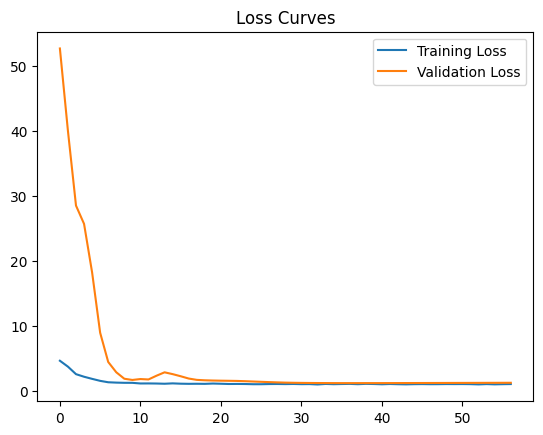

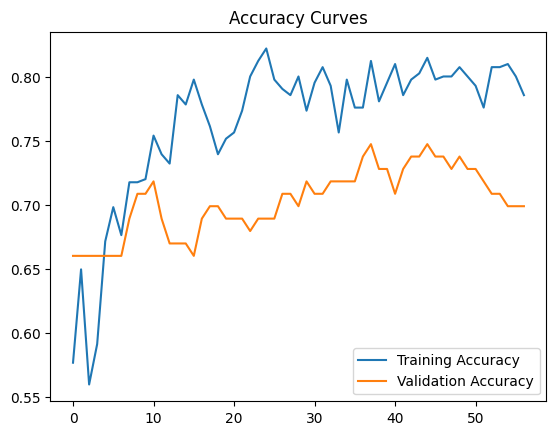

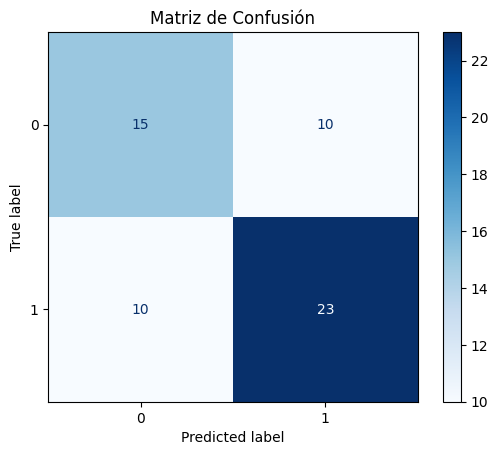

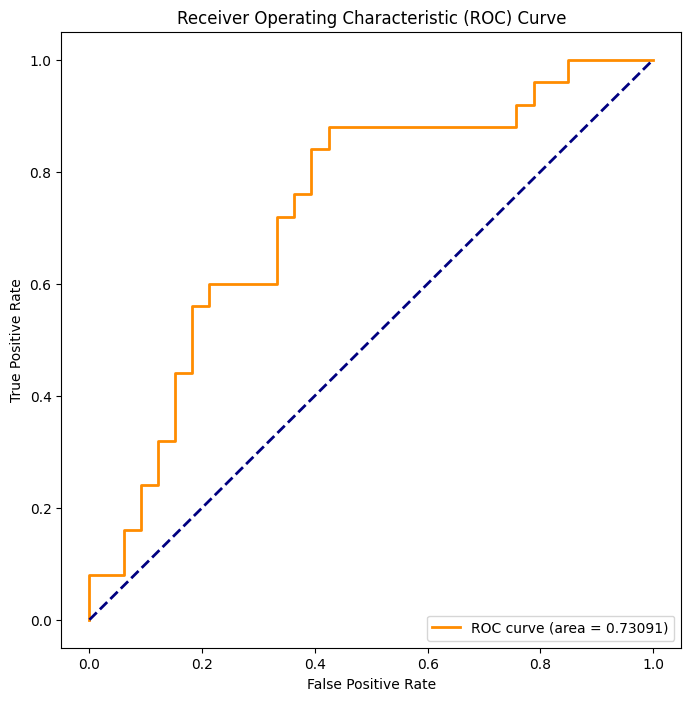


Entrenando Fold 2...
Epoch 1/999999
4/4 [==============================] - 22s 4s/step - loss: 4.6046 - accuracy: 0.5888 - val_loss: 52.2597 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 3.4075 - accuracy: 0.6521 - val_loss: 38.3250 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 2.5704 - accuracy: 0.5547 - val_loss: 28.3032 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 2.0796 - accuracy: 0.6131 - val_loss: 24.1475 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.6598 - accuracy: 0.6934 - val_loss: 16.5724 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.4161 - accuracy: 0.7324 - val_loss: 7.6494 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 7/999999
4/4 [=======================

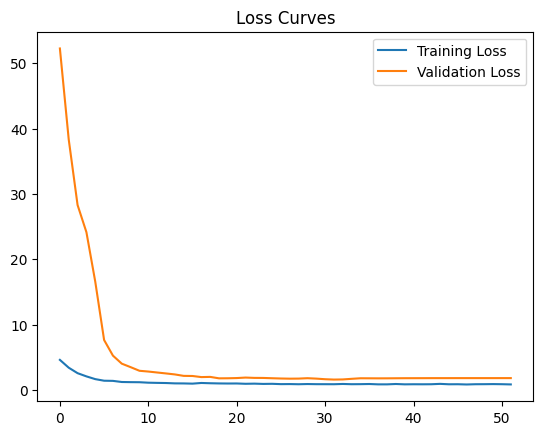

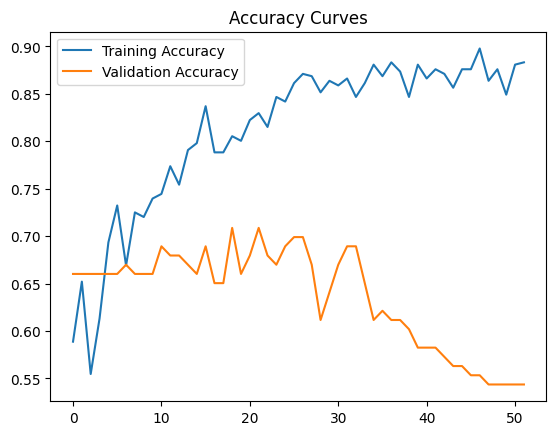

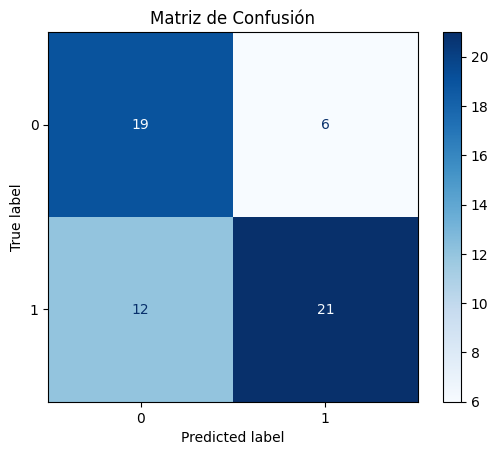

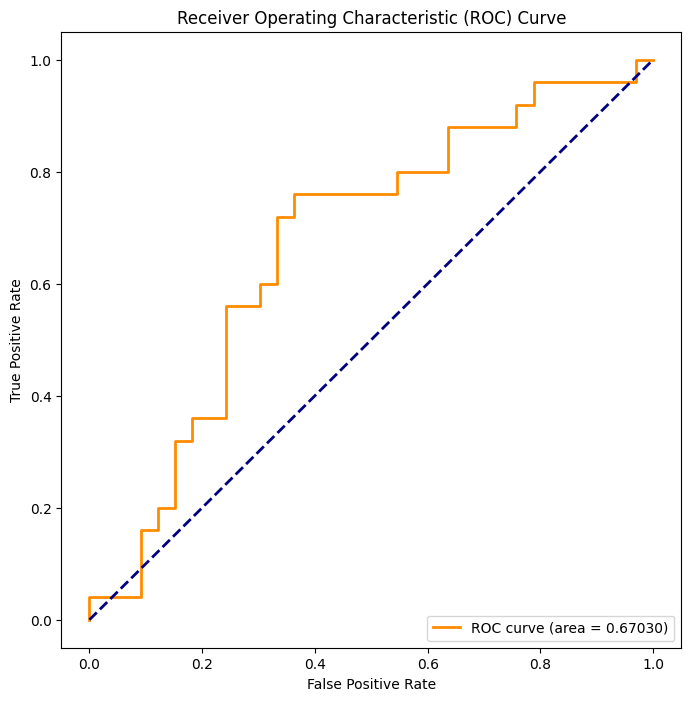


Entrenando Fold 3...
Epoch 1/999999
4/4 [==============================] - 22s 4s/step - loss: 4.9072 - accuracy: 0.5547 - val_loss: 49.0328 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 3.3999 - accuracy: 0.6326 - val_loss: 37.0566 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 2.6514 - accuracy: 0.5280 - val_loss: 29.9868 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 1.9927 - accuracy: 0.6010 - val_loss: 24.6077 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.7058 - accuracy: 0.6691 - val_loss: 16.3915 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.3798 - accuracy: 0.6861 - val_loss: 9.0937 - val_accuracy: 0.6408 - lr: 0.0010
Epoch 7/999999
4/4 [=======================

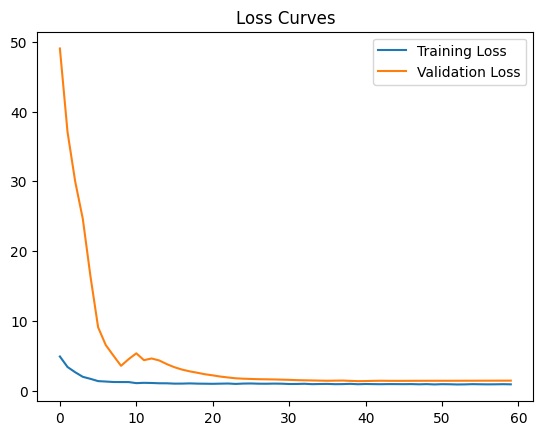

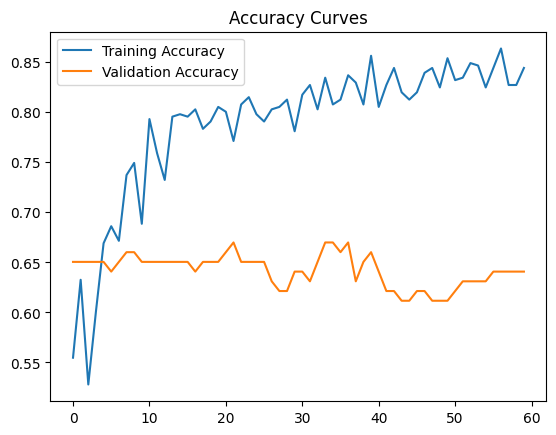

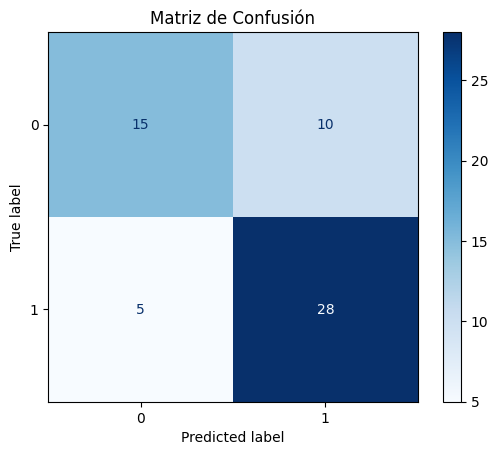

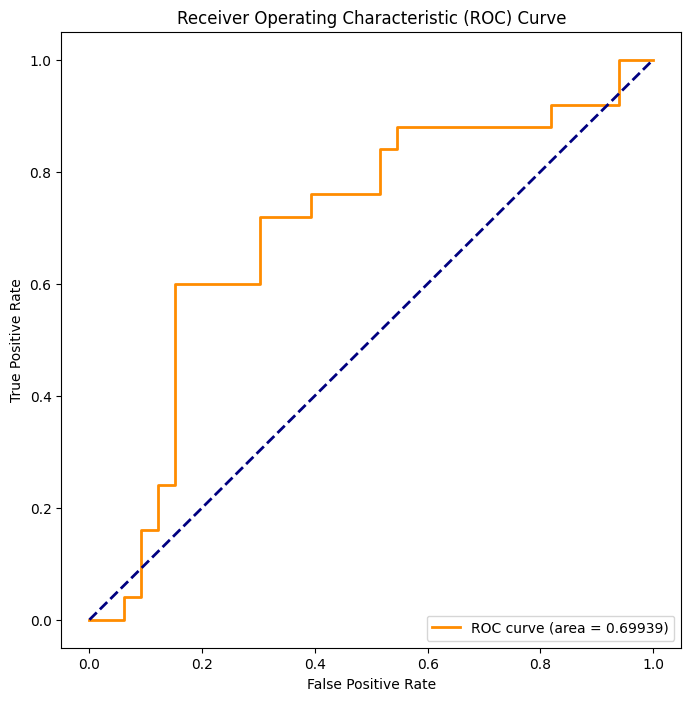


Entrenando Fold 4...
Epoch 1/999999
4/4 [==============================] - 23s 4s/step - loss: 4.0905 - accuracy: 0.6131 - val_loss: 50.6533 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 16s 4s/step - loss: 3.2061 - accuracy: 0.6691 - val_loss: 35.7328 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 2.3615 - accuracy: 0.5864 - val_loss: 27.2617 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 1.8445 - accuracy: 0.6545 - val_loss: 22.0088 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.4753 - accuracy: 0.6934 - val_loss: 11.8857 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.2487 - accuracy: 0.6642 - val_loss: 5.7257 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 7/999999
4/4 [=======================

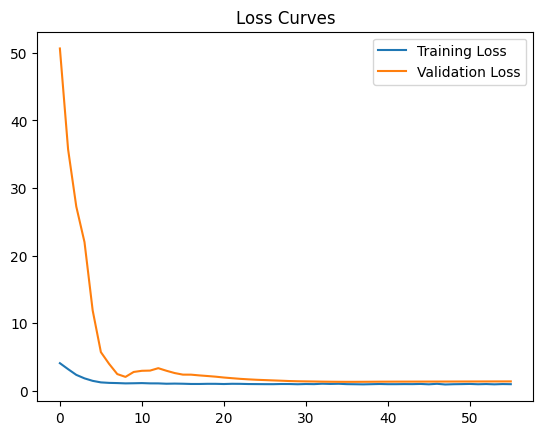

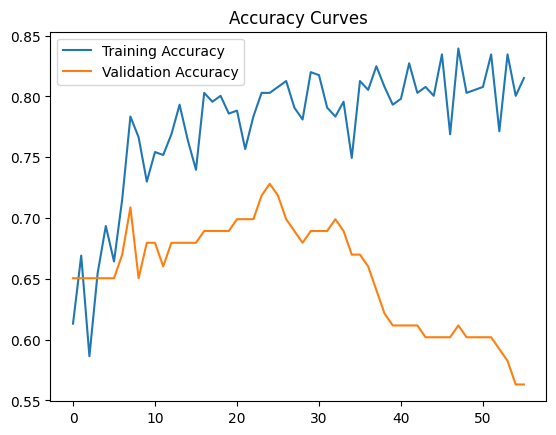

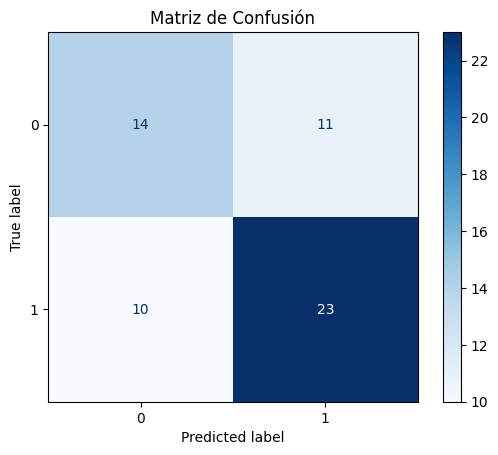

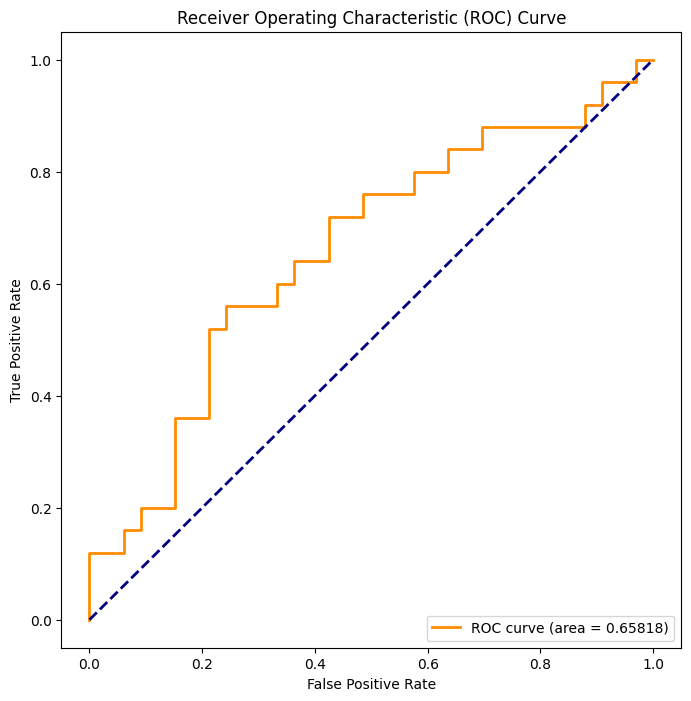


Entrenando Fold 5...
Epoch 1/999999
4/4 [==============================] - 48s 13s/step - loss: 4.8987 - accuracy: 0.5413 - val_loss: 49.1783 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 15s 4s/step - loss: 3.5290 - accuracy: 0.6408 - val_loss: 35.5517 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 15s 4s/step - loss: 2.4136 - accuracy: 0.5874 - val_loss: 25.2386 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 15s 4s/step - loss: 1.9217 - accuracy: 0.6335 - val_loss: 20.9641 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 15s 4s/step - loss: 1.8316 - accuracy: 0.6772 - val_loss: 12.9617 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 15s 4s/step - loss: 1.3064 - accuracy: 0.6990 - val_loss: 4.4921 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 7/999999
4/4 [======================

2/2 [==============================] - 1s 308ms/step


----------------------------------------------
 METRICAS DE EVALUACIÓN PARA EL MODELO
----------------------------------------------
Accuracy on test set: 63.79310%
Loss on test set: 138.62925%
Precision on test set: 57.69231%
Recall on test set: 60.00000%
F1 Score on test set: 58.82353%
ROC AUC score on test set: 71.87879
El Score oficial del Challenge es: 36.27451


----------------------------------------------
 REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO
----------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        33
           1       0.58      0.60      0.59        25

    accuracy                           0.64        58
   macro avg       0.63      0.63      0.63        58
weighted avg       0.64      0.64      0.64        58



----------------------------------------------
 GRÁFICAS DE EVALUACIÓN
---------------------

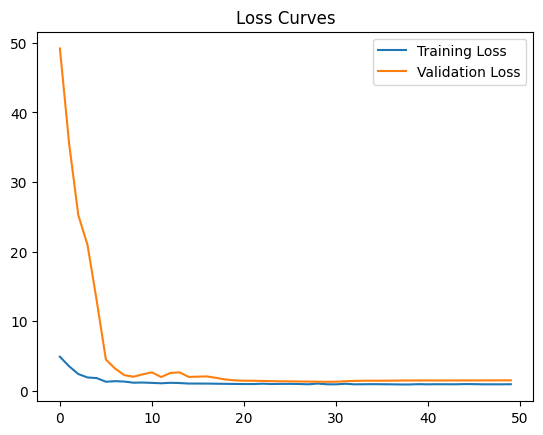

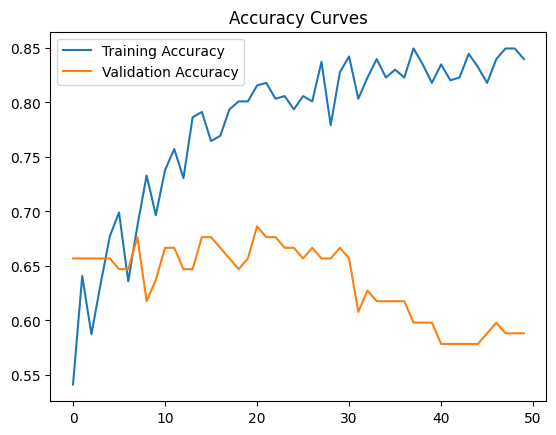

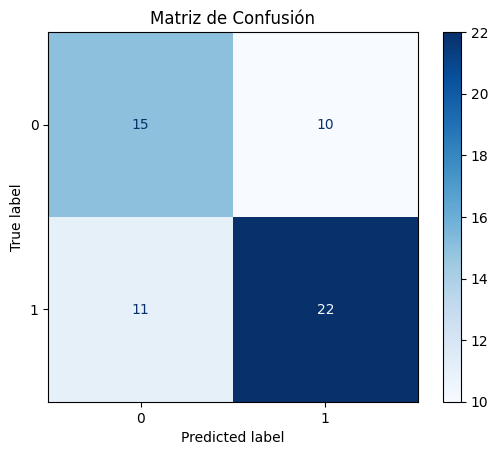

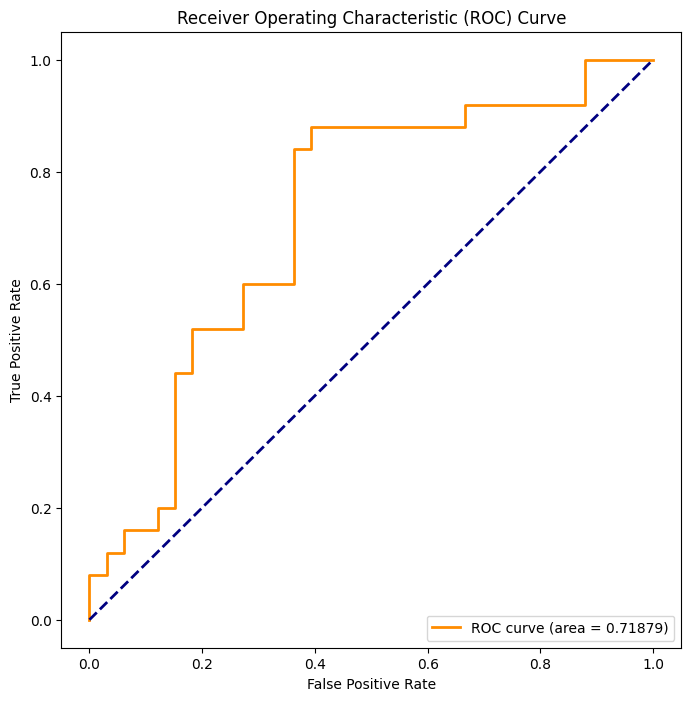



----------------------------------------------
 METRICAS DE EVALUACIÓN FINALES EN CADA FOLD
----------------------------------------------


 PARA ENTRENAMIENTO 
El accuracy de cada fold es:  [0.8442822098731995, 0.8442822098731995, 0.9124087691307068, 0.9124087691307068, 0.9051094651222229, 0.9051094651222229, 0.8442822098731995, 0.8442822098731995, 0.8980582356452942, 0.8980582356452942]
La Media del accuracy de los k fols es: 0.8808281779289245
La Desviación Estandar del accuracy de los k fols es: 0.03018279344125426
El accuracy mínimo es: 0.8506453844876702
El accuracy máximo es: 0.9110109713701788


 PARA VALIDACIÓN 
El accuracy de cada fold es:  [0.737864077091217, 0.737864077091217, 0.6893203854560852, 0.6893203854560852, 0.6601941585540771, 0.6601941585540771, 0.6699029207229614, 0.6699029207229614, 0.6666666865348816, 0.6666666865348816]
La Media del accuracy de los k fols es: 0.6847896456718445
La Desviación Estandar del accuracy de los k fols es: 0.02825744888565196
El acc

In [ ]:
# Combinar datos para k-fold
X_combined = np.concatenate((X_train1, X_val1), axis=0)
y_combined = np.concatenate((y_train1, y_val1), axis=0)

n_folds = 5

#Para guardar los mejores accuracys
fold_train_accuracies = []
fold_val_accuracies = []
fold_test_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_roc_aucs = []
fold_score = []

# StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

initial_weights = None

# Entrenamiento con k-fold estratificado
for fold, (train_index, val_index) in enumerate(stratkf.split(X_combined, y_combined)):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]


    # Guardar los pesos iniciales en la primera iteración
    if initial_weights is None:
        initial_weights = model.get_weights()

    # Restablecer pesos a los valores iniciales
    model.set_weights(initial_weights)

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entrenamiento con callbacks para guardar el mejor modelo
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=20,verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,verbose=1),
        ModelCheckpoint(filepath=f"best_model_fold_{fold + 1}_P5C1_.keras", save_best_only=True)]

    print(f"\nEntrenando Fold {fold + 1}...")

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=999999,
        batch_size=128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks
    )

    #METRICAS DE EVALUACION DEL MODELO
    best_model = load_model(f"best_model_fold_{fold + 1}_P5C1_.keras")

    # Evaluar el mejor modelo en el conjunto de prueba

    test_loss, test_accuracy = best_model.evaluate(X_test1, y_test1)
    fold_test_accuracies.append(test_accuracy)

    # Evaluar el mejor modelo en el conjunto de entrenamiento
    train_loss, train_accuracy = best_model.evaluate(X_train_fold, y_train_fold)
    fold_train_accuracies.append(train_accuracy)

    # Evaluar el mejor modelo en el conjunto de validación
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)
    fold_val_accuracies.append(val_accuracy)


    # Obtener las predicciones en el conjunto de prueba
    y_pred_probs = best_model.predict(X_test1)

    # Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
    threshold = 0.5
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convertir las etiquetas a clases binarias
    y_true_binary = (y_test1 > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
    conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)
    fold_test_accuracies.append(test_accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_roc_aucs.append(roc_auc)



    # Extraer los valores de TP, FP, FN y TN de la matriz de confusión
    TP = conf_matrix[0, 0]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives
    TN = conf_matrix[1, 1]  # True Negatives

    # Calcular el score del challenge
    score = (TP + TN) / (TP + TN + FP + (5 * FN))
    fold_score.append(score)


    print("\n")
    print("----------------------------------------------")
    print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
    print("----------------------------------------------")
    print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
    print(f'Loss on test set: {test_loss * 100:.5f}%')
    print(f'Precision on test set: {precision * 100:.5f}%')
    print(f'Recall on test set: {recall * 100:.5f}%')
    print(f'F1 Score on test set: {f1 * 100:.5f}%')
    print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
    print(f'El Score oficial del Challenge es: {score * 100:.5f}')
    #######
    print("\n")
    print("----------------------------------------------")
    print(" REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO")
    print("----------------------------------------------")
    report=classification_report(y_true_binary,y_pred_binary)
    print(report)


    #######
    print("\n")
    print("----------------------------------------------")
    print(" GRÁFICAS DE EVALUACIÓN")
    print("----------------------------------------------")
    # Graficar curvas de pérdida y precisión
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    print("\n")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()
    print("\n")
    # Plotear la matriz de confusión
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusión')
    plt.show()
    print("\n")
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


print("\n")
print("----------------------------------------------")
print(" METRICAS DE EVALUACIÓN FINALES EN CADA FOLD")
print("----------------------------------------------")
print("\n")
print(" PARA ENTRENAMIENTO ")
print('El accuracy de cada fold es: ',fold_train_accuracies)
Media_TRAIN = np.mean(fold_train_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TRAIN}')
Desv_std_TRAIN = np.std(fold_train_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TRAIN}')

Min_TRAIN = Media_TRAIN - Desv_std_TRAIN
Max_TRAIN = Media_TRAIN + Desv_std_TRAIN
print(f'El accuracy mínimo es: {Min_TRAIN}')
print(f'El accuracy máximo es: {Max_TRAIN}')

print("\n")
print(" PARA VALIDACIÓN ")
print('El accuracy de cada fold es: ',fold_val_accuracies)
Media_VAL = np.mean(fold_val_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_VAL}')
Desv_std_VAL = np.std(fold_val_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_VAL}')

Min_VAL = Media_VAL - Desv_std_VAL
Max_VAL = Media_VAL + Desv_std_VAL
print(f'El accuracy mínimo es: {Min_VAL}')
print(f'El accuracy máximo es: {Max_VAL}')

print("\n")
print(" PARA TESTEO ")
print('El accuracy de cada fold es: ',fold_test_accuracies)
Media_TEST= np.mean(fold_test_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TEST}')
Desv_std_TEST = np.std(fold_test_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TEST}')

Min_TEST = Media_TEST - Desv_std_TEST
Max_TEST = Media_TEST + Desv_std_TEST
print(f'El accuracy mínimo es: {Min_TEST}')
print(f'El accuracy máximo es: {Max_TEST}')


print("\n")
print(" PARA LA MÉTRICA DE PRECISIÓN ")
print('La precisión cada fold es: ',fold_precisions)
mean_precision = np.mean(fold_precisions)
print(f'La Media de la precisión de los k fols es: {mean_precision}')
std_precision = np.std(fold_precisions)
print(f'La Desviación Estandar de la precisión de los k fols es: {std_precision}')
Min_precision = mean_precision - std_precision
Max_precision = mean_precision + std_precision
print(f'La precisión mínima es: {Min_precision}')
print(f'La precisión máxima es: {Max_precision}')


print("\n")
print(" PARA LA MÉTRICA DE RECALL ")
print('El recall de cada fold es: ',fold_recalls)
mean_recall = np.mean(fold_recalls)
print(f'La Media del recall de los k fols es: {mean_recall}')
std_recall = np.std(fold_recalls)
print(f'La Desviación Estandar del recall de los k fols es: {std_recall}')
Min_recall = mean_recall - std_recall
Max_recall = mean_recall + std_recall
print(f'El Recall mínimo es: {Min_recall}')
print(f'El Recall máximo es: {Max_recall}')


print("\n")
print(" PARA LA MÉTRICA DE F1 SCORE ")
print('El F1 SCORE de cada fold es: ',fold_f1_scores)
mean_f1_score = np.mean(fold_f1_scores)
print(f'La Media del F1 SCORE de los k fols es: {mean_f1_score}')
std_f1_score = np.std(fold_f1_scores)
print(f'La Desviación Estandar del F1 SCORE de los k fols es: {std_f1_score}')
Min_f1_score = mean_f1_score - std_f1_score
Max_f1_score = mean_f1_score + std_f1_score
print(f'El F1 SCORE mínimo es: {Min_f1_score}')
print(f'El F1 SCORE máximo es: {Max_f1_score}')


print("\n")
print(" PARA EL ROC SCORE ")
print('El ROC SCORE de cada fold es: ',fold_roc_aucs)
mean_roc_auc = np.mean(fold_roc_aucs)
print(f'La Media del ROC SCORE de los k fols es: {mean_roc_auc}')
std_roc_auc = np.std(fold_roc_aucs)
print(f'La Desviación Estandar del ROC SCORE de los k fols es: {std_roc_auc}')
Min_roc_auc = mean_roc_auc - std_roc_auc
Max_roc_auc = mean_roc_auc + std_roc_auc
print(f'El ROC SCORE mínimo es: {Min_roc_auc}')
print(f'El ROC SCORE máximo es: {Max_roc_auc}')


print("\n")
print(" PARA EL SCORE DEL PHYSIONET")
print('El SCORE de cada fold es: ',fold_score)
mean_score = np.mean(fold_score)
print(f'La Media del SCORE de los k fols es: {mean_score}')
std_score = np.std(fold_score)
print(f'La Desviación Estandar del SCORE de los k fols es: {std_score}')
Min_score = mean_score - std_score
Max_score = mean_score + std_score
print(f'El SCORE mínimo es: {Min_score}')
print(f'El SCORE máximo es: {Max_score}')

###PRUEBA 6. MB2 + 5 folds  + Callbacks (Early stopping con 20 épocas de paciencia  + REDUCE + Save) + Dropout = 0.85 + L2 = 0.0005

In [ ]:
samples_per_signal = 75000
num_of_signals = 3


# Definir el valor de regularización L2
l2_reg = 0.0005

input_shape = (samples_per_signal,num_of_signals)
inputs = keras.Input(shape=(input_shape))

x = layers.BatchNormalization()(inputs)


x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=11, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
x1 = layers.Dropout(0.85)(x1)
x1 = tf.keras.layers.Conv1D(filters=64, kernel_size=11, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Activation("relu")(x1)
y1 = layers.GlobalMaxPooling1D()(x1)

x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=75, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
x2 = layers.Dropout(0.85)(x2)
x2 = tf.keras.layers.Conv1D(filters=64, kernel_size=75, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Activation("relu")(x2)
y2 = layers.GlobalMaxPooling1D()(x2)

x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=150, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
x3 = layers.Dropout(0.85)(x3)
x3 = tf.keras.layers.Conv1D(filters=64, kernel_size=150, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x3)
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation("relu")(x3)
y3 = layers.GlobalMaxPooling1D()(x3)

x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
x4 = layers.Dropout(0.85)(x4)
x4 = tf.keras.layers.Conv1D(filters=64, kernel_size=400, strides=5, padding="same", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(l2_reg))(x4)
x4 = layers.BatchNormalization()(x4)
x4 = layers.Activation("relu")(x4)
y4 = layers.GlobalMaxPooling1D()(x4)

y = concatenate([y1, y2, y3, y4])

#y = layers.Dropout(0.3)(y)

outputs = layers.Dense(1, activation="sigmoid", kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(l2_reg))(y)

model = keras.Model(inputs=inputs, outputs=outputs, name="signal_encoder")

# Diagrama de bloques
keras.utils.plot_model(model, "modelo.png", show_shapes=True)

# Resumen
model.summary()

Model: "signal_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75000, 3)]           0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 75000, 3)             12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 15000, 64)            2176      ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 15000, 64)            14464     ['batch_normaliza

In [ ]:
# Compila el modelo
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    loss= keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])


Entrenando Fold 1...
Epoch 1/999999
4/4 [==============================] - 110s 11s/step - loss: 3.2746 - accuracy: 0.5134 - val_loss: 14.4077 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 13s 3s/step - loss: 2.7787 - accuracy: 0.6545 - val_loss: 14.7761 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 14s 3s/step - loss: 1.8565 - accuracy: 0.6156 - val_loss: 11.3008 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 13s 3s/step - loss: 1.6312 - accuracy: 0.6399 - val_loss: 15.0199 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 13s 3s/step - loss: 1.6518 - accuracy: 0.7007 - val_loss: 11.9982 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 14s 3s/step - loss: 1.3222 - accuracy: 0.6837 - val_loss: 5.7853 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 7/999999
4/4 [=====================

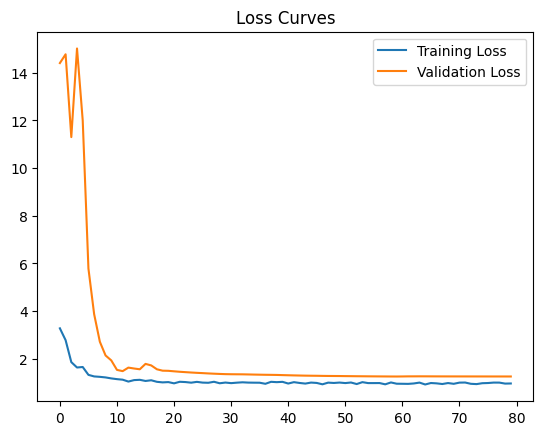

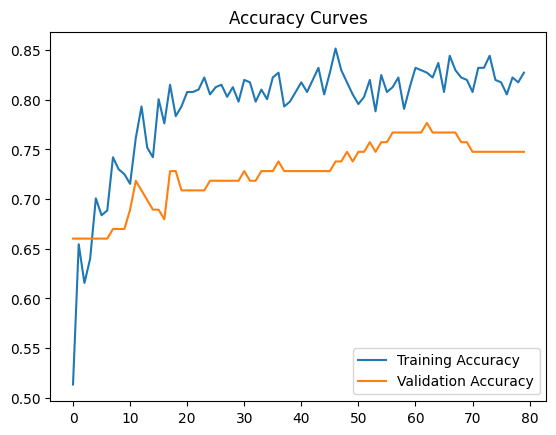

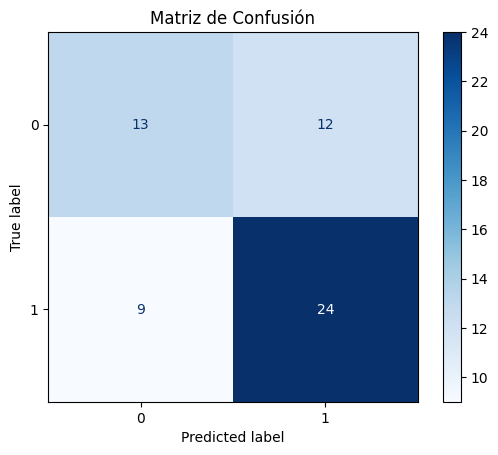

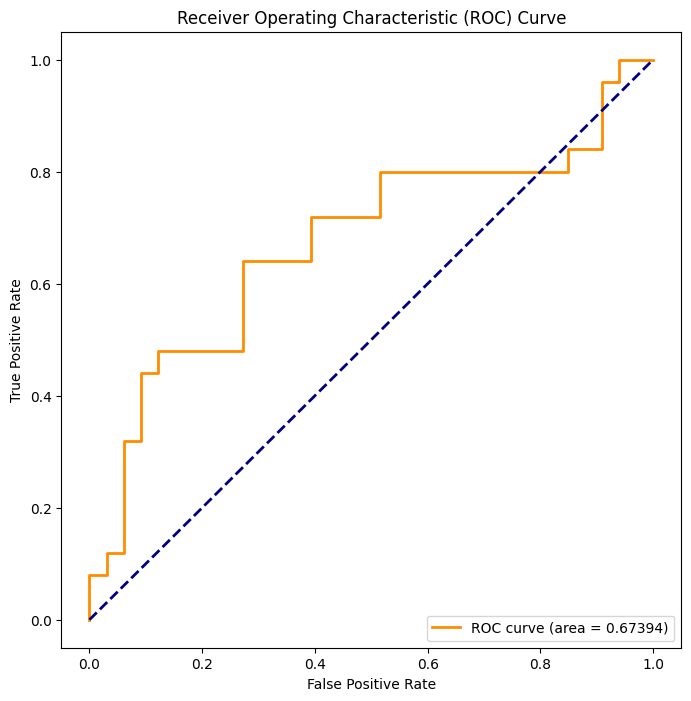


Entrenando Fold 2...
Epoch 1/999999
4/4 [==============================] - 21s 3s/step - loss: 2.6771 - accuracy: 0.5547 - val_loss: 10.1868 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 14s 3s/step - loss: 1.6249 - accuracy: 0.6667 - val_loss: 6.8310 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 14s 3s/step - loss: 1.4666 - accuracy: 0.6399 - val_loss: 14.0275 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 13s 3s/step - loss: 1.4406 - accuracy: 0.7421 - val_loss: 9.9867 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 14s 3s/step - loss: 1.2140 - accuracy: 0.7324 - val_loss: 5.3823 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 13s 3s/step - loss: 1.2812 - accuracy: 0.6618 - val_loss: 5.7008 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 7/999999
4/4 [==========================

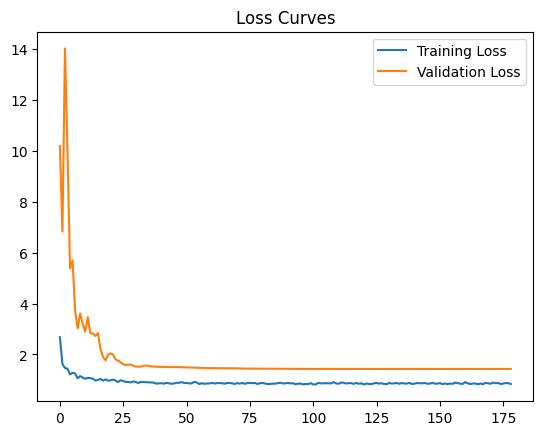

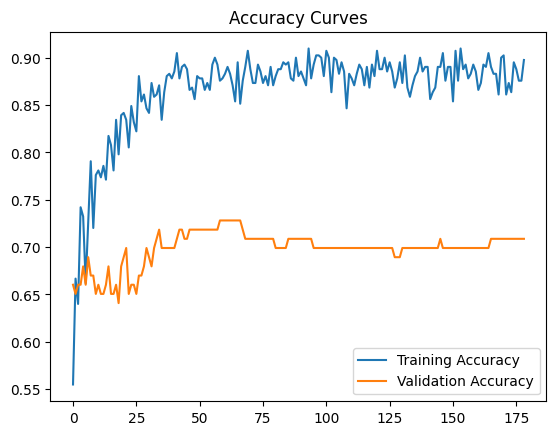

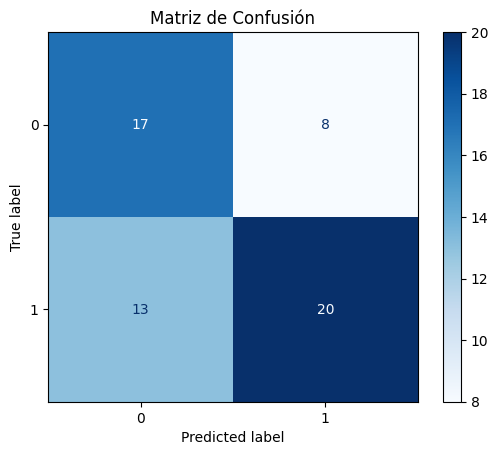

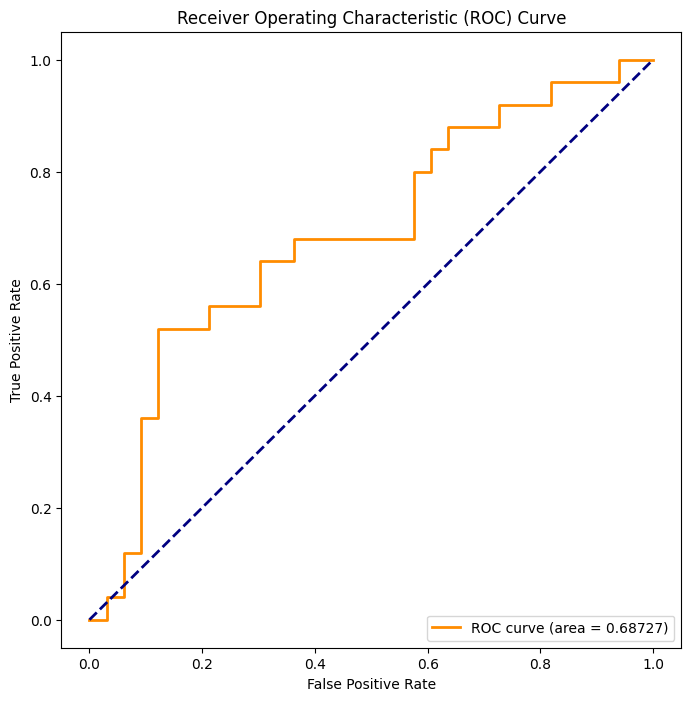


Entrenando Fold 3...
Epoch 1/999999
4/4 [==============================] - 21s 4s/step - loss: 2.3900 - accuracy: 0.5937 - val_loss: 7.5351 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 14s 3s/step - loss: 1.7971 - accuracy: 0.6229 - val_loss: 2.7479 - val_accuracy: 0.6990 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 14s 3s/step - loss: 1.4225 - accuracy: 0.6740 - val_loss: 11.1389 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 13s 3s/step - loss: 1.7048 - accuracy: 0.6764 - val_loss: 7.6924 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 13s 3s/step - loss: 1.4316 - accuracy: 0.6423 - val_loss: 9.6898 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - ETA: 0s - loss: 1.2913 - accuracy: 0.7299
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
4/4 [========================

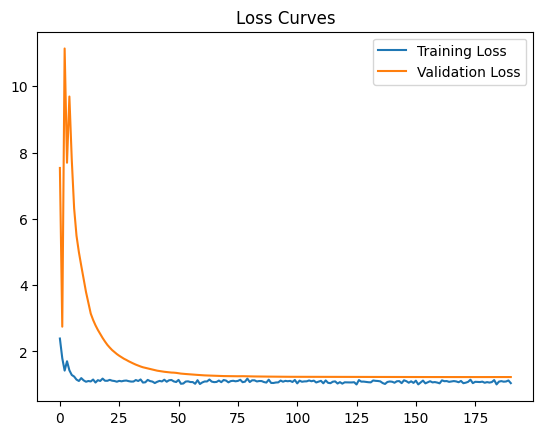

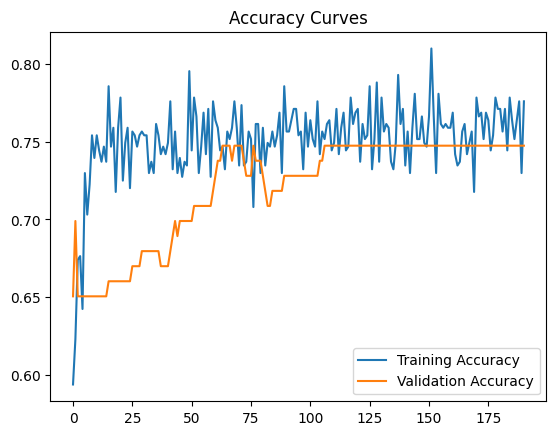

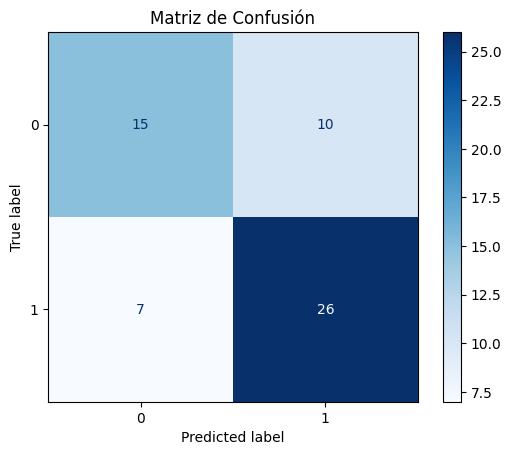

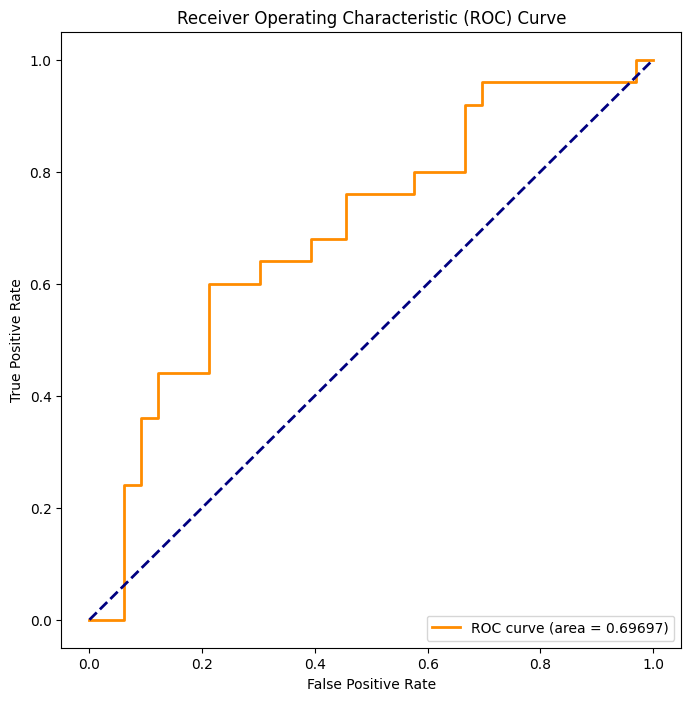


Entrenando Fold 4...
Epoch 1/999999
4/4 [==============================] - 21s 4s/step - loss: 3.2922 - accuracy: 0.4939 - val_loss: 13.4647 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 13s 3s/step - loss: 2.6860 - accuracy: 0.6594 - val_loss: 15.2988 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 13s 3s/step - loss: 1.9047 - accuracy: 0.5523 - val_loss: 14.4290 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 13s 3s/step - loss: 1.5020 - accuracy: 0.6788 - val_loss: 16.9628 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 14s 3s/step - loss: 1.6090 - accuracy: 0.7105 - val_loss: 11.0793 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 14s 3s/step - loss: 1.5168 - accuracy: 0.6107 - val_loss: 6.0541 - val_accuracy: 0.6505 - lr: 0.0010
Epoch 7/999999
4/4 [=======================

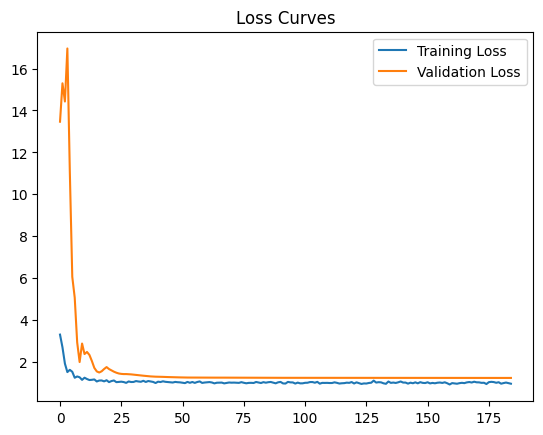

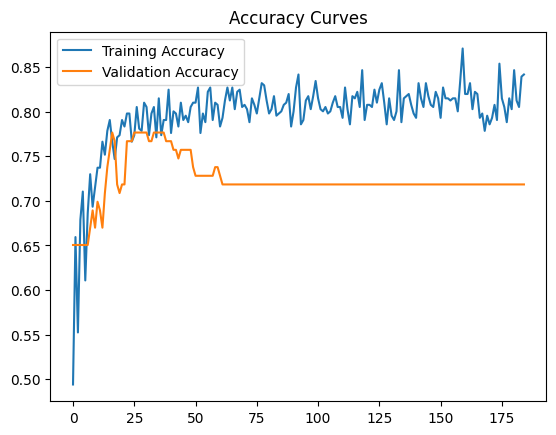

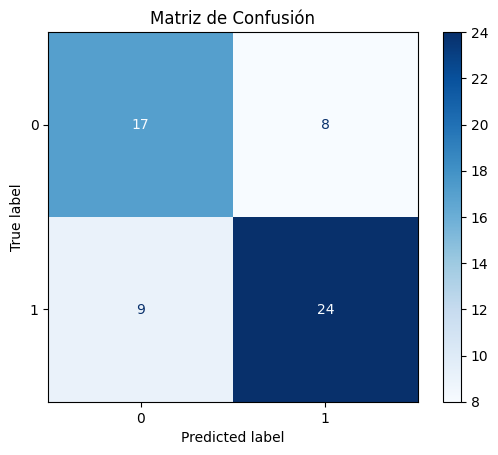

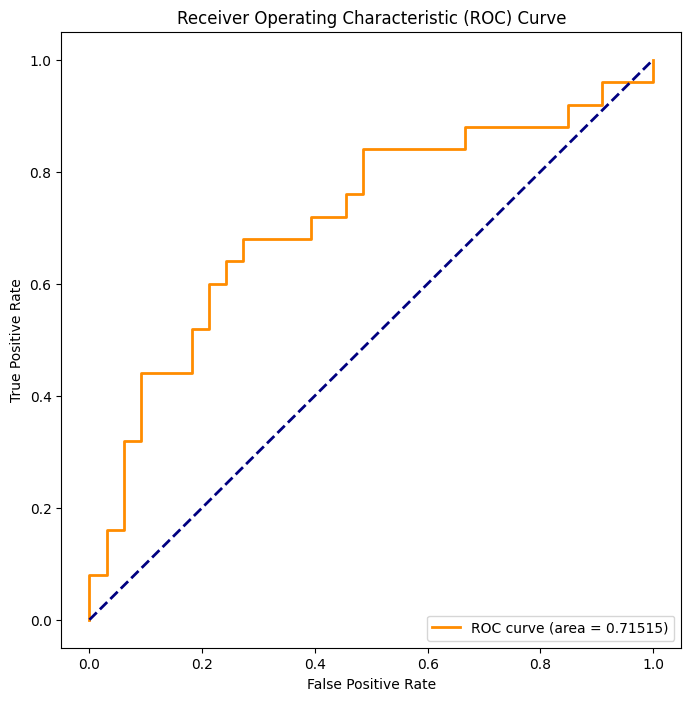


Entrenando Fold 5...
Epoch 1/999999
4/4 [==============================] - 44s 11s/step - loss: 2.8476 - accuracy: 0.5267 - val_loss: 11.5612 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 2/999999
4/4 [==============================] - 14s 3s/step - loss: 2.4846 - accuracy: 0.6553 - val_loss: 7.2837 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 3/999999
4/4 [==============================] - 13s 3s/step - loss: 1.8177 - accuracy: 0.5413 - val_loss: 10.1479 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 4/999999
4/4 [==============================] - 13s 3s/step - loss: 1.6080 - accuracy: 0.6893 - val_loss: 10.8390 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 5/999999
4/4 [==============================] - 13s 3s/step - loss: 1.4570 - accuracy: 0.6748 - val_loss: 4.7767 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/999999
4/4 [==============================] - 14s 3s/step - loss: 1.3935 - accuracy: 0.6359 - val_loss: 4.2900 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 7/999999
4/4 [========================

In [ ]:
# Combinar datos para k-fold
X_combined = np.concatenate((X_train1, X_val1), axis=0)
y_combined = np.concatenate((y_train1, y_val1), axis=0)

n_folds = 5

#Para guardar los mejores accuracys
fold_train_accuracies = []
fold_val_accuracies = []
fold_test_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
fold_roc_aucs = []
fold_score = []

# StratifiedKFold
stratkf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

initial_weights = None

# Entrenamiento con k-fold estratificado
for fold, (train_index, val_index) in enumerate(stratkf.split(X_combined, y_combined)):
    X_train_fold, X_val_fold = X_combined[train_index], X_combined[val_index]
    y_train_fold, y_val_fold = y_combined[train_index], y_combined[val_index]


    # Guardar los pesos iniciales en la primera iteración
    if initial_weights is None:
        initial_weights = model.get_weights()

    # Restablecer pesos a los valores iniciales
    model.set_weights(initial_weights)

    # Compilar el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entrenamiento con callbacks para guardar el mejor modelo
    callbacks = [
        EarlyStopping(monitor='val_loss',patience=20,verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,verbose=1),
        ModelCheckpoint(filepath=f"best_model_fold_{fold + 1}_P6C1_.keras", save_best_only=True)]

    print(f"\nEntrenando Fold {fold + 1}...")

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=999999,
        batch_size=128,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks
    )

    #METRICAS DE EVALUACION DEL MODELO
    best_model = load_model(f"best_model_fold_{fold + 1}_P6C1_.keras")

    # Evaluar el mejor modelo en el conjunto de prueba

    test_loss, test_accuracy = best_model.evaluate(X_test1, y_test1)
    fold_test_accuracies.append(test_accuracy)

    # Evaluar el mejor modelo en el conjunto de entrenamiento
    train_loss, train_accuracy = best_model.evaluate(X_train_fold, y_train_fold)
    fold_train_accuracies.append(train_accuracy)

    # Evaluar el mejor modelo en el conjunto de validación
    val_loss, val_accuracy = best_model.evaluate(X_val_fold, y_val_fold)
    fold_val_accuracies.append(val_accuracy)


    # Obtener las predicciones en el conjunto de prueba
    y_pred_probs = best_model.predict(X_test1)

    # Convertir las probabilidades a clases binarias basadas en un umbral (PUEDE SER EL ERROR)
    threshold = 0.5
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convertir las etiquetas a clases binarias
    y_true_binary = (y_test1 > 0.5).astype(int)

    # Calcular métricas
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs)
    conf_matrix = confusion_matrix(y_true_binary, y_pred_binary, labels=[1, 0])

    fold_train_accuracies.append(train_accuracy)
    fold_val_accuracies.append(val_accuracy)
    fold_test_accuracies.append(test_accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1_scores.append(f1)
    fold_roc_aucs.append(roc_auc)



    # Extraer los valores de TP, FP, FN y TN de la matriz de confusión
    TP = conf_matrix[0, 0]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives
    TN = conf_matrix[1, 1]  # True Negatives

    # Calcular el score del challenge
    score = (TP + TN) / (TP + TN + FP + (5 * FN))
    fold_score.append(score)


    print("\n")
    print("----------------------------------------------")
    print(f" METRICAS DE EVALUACIÓN PARA EL MODELO")
    print("----------------------------------------------")
    print(f'Accuracy on test set: {test_accuracy * 100:.5f}%')
    print(f'Loss on test set: {test_loss * 100:.5f}%')
    print(f'Precision on test set: {precision * 100:.5f}%')
    print(f'Recall on test set: {recall * 100:.5f}%')
    print(f'F1 Score on test set: {f1 * 100:.5f}%')
    print(f'ROC AUC score on test set: {roc_auc * 100:.5f}')
    print(f'El Score oficial del Challenge es: {score * 100:.5f}')
    #######
    print("\n")
    print("----------------------------------------------")
    print(" REPORTE DE MÉTRICAS CON CLASES BALANCEADAS PARA EL MODELO")
    print("----------------------------------------------")
    report=classification_report(y_true_binary,y_pred_binary)
    print(report)


    #######
    print("\n")
    print("----------------------------------------------")
    print(" GRÁFICAS DE EVALUACIÓN")
    print("----------------------------------------------")
    # Graficar curvas de pérdida y precisión
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')
    plt.show()
    print("\n")
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')
    plt.show()
    print("\n")
    # Plotear la matriz de confusión
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Matriz de Confusión')
    plt.show()
    print("\n")
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.5f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


print("\n")
print("----------------------------------------------")
print(" METRICAS DE EVALUACIÓN FINALES EN CADA FOLD")
print("----------------------------------------------")
print("\n")
print(" PARA ENTRENAMIENTO ")
print('El accuracy de cada fold es: ',fold_train_accuracies)
Media_TRAIN = np.mean(fold_train_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TRAIN}')
Desv_std_TRAIN = np.std(fold_train_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TRAIN}')

Min_TRAIN = Media_TRAIN - Desv_std_TRAIN
Max_TRAIN = Media_TRAIN + Desv_std_TRAIN
print(f'El accuracy mínimo es: {Min_TRAIN}')
print(f'El accuracy máximo es: {Max_TRAIN}')

print("\n")
print(" PARA VALIDACIÓN ")
print('El accuracy de cada fold es: ',fold_val_accuracies)
Media_VAL = np.mean(fold_val_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_VAL}')
Desv_std_VAL = np.std(fold_val_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_VAL}')

Min_VAL = Media_VAL - Desv_std_VAL
Max_VAL = Media_VAL + Desv_std_VAL
print(f'El accuracy mínimo es: {Min_VAL}')
print(f'El accuracy máximo es: {Max_VAL}')

print("\n")
print(" PARA TESTEO ")
print('El accuracy de cada fold es: ',fold_test_accuracies)
Media_TEST= np.mean(fold_test_accuracies)
print(f'La Media del accuracy de los k fols es: {Media_TEST}')
Desv_std_TEST = np.std(fold_test_accuracies)
print(f'La Desviación Estandar del accuracy de los k fols es: {Desv_std_TEST}')

Min_TEST = Media_TEST - Desv_std_TEST
Max_TEST = Media_TEST + Desv_std_TEST
print(f'El accuracy mínimo es: {Min_TEST}')
print(f'El accuracy máximo es: {Max_TEST}')


print("\n")
print(" PARA LA MÉTRICA DE PRECISIÓN ")
print('La precisión cada fold es: ',fold_precisions)
mean_precision = np.mean(fold_precisions)
print(f'La Media de la precisión de los k fols es: {mean_precision}')
std_precision = np.std(fold_precisions)
print(f'La Desviación Estandar de la precisión de los k fols es: {std_precision}')
Min_precision = mean_precision - std_precision
Max_precision = mean_precision + std_precision
print(f'La precisión mínima es: {Min_precision}')
print(f'La precisión máxima es: {Max_precision}')


print("\n")
print(" PARA LA MÉTRICA DE RECALL ")
print('El recall de cada fold es: ',fold_recalls)
mean_recall = np.mean(fold_recalls)
print(f'La Media del recall de los k fols es: {mean_recall}')
std_recall = np.std(fold_recalls)
print(f'La Desviación Estandar del recall de los k fols es: {std_recall}')
Min_recall = mean_recall - std_recall
Max_recall = mean_recall + std_recall
print(f'El Recall mínimo es: {Min_recall}')
print(f'El Recall máximo es: {Max_recall}')


print("\n")
print(" PARA LA MÉTRICA DE F1 SCORE ")
print('El F1 SCORE de cada fold es: ',fold_f1_scores)
mean_f1_score = np.mean(fold_f1_scores)
print(f'La Media del F1 SCORE de los k fols es: {mean_f1_score}')
std_f1_score = np.std(fold_f1_scores)
print(f'La Desviación Estandar del F1 SCORE de los k fols es: {std_f1_score}')
Min_f1_score = mean_f1_score - std_f1_score
Max_f1_score = mean_f1_score + std_f1_score
print(f'El F1 SCORE mínimo es: {Min_f1_score}')
print(f'El F1 SCORE máximo es: {Max_f1_score}')


print("\n")
print(" PARA EL ROC SCORE ")
print('El ROC SCORE de cada fold es: ',fold_roc_aucs)
mean_roc_auc = np.mean(fold_roc_aucs)
print(f'La Media del ROC SCORE de los k fols es: {mean_roc_auc}')
std_roc_auc = np.std(fold_roc_aucs)
print(f'La Desviación Estandar del ROC SCORE de los k fols es: {std_roc_auc}')
Min_roc_auc = mean_roc_auc - std_roc_auc
Max_roc_auc = mean_roc_auc + std_roc_auc
print(f'El ROC SCORE mínimo es: {Min_roc_auc}')
print(f'El ROC SCORE máximo es: {Max_roc_auc}')


print("\n")
print(" PARA EL SCORE DEL PHYSIONET")
print('El SCORE de cada fold es: ',fold_score)
mean_score = np.mean(fold_score)
print(f'La Media del SCORE de los k fols es: {mean_score}')
std_score = np.std(fold_score)
print(f'La Desviación Estandar del SCORE de los k fols es: {std_score}')
Min_score = mean_score - std_score
Max_score = mean_score + std_score
print(f'El SCORE mínimo es: {Min_score}')
print(f'El SCORE máximo es: {Max_score}')